# Visualization of networks
Based on precision matrices

### Imports

In [1]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading data

In [2]:
dataset = 'train'
test = False

In [3]:
results_ern_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_models_{dataset}.pkl")
results_ern_lat_demo_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_cov_fal_models_{dataset}.pkl")
results_crn_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_models_{dataset}.pkl")
results_crn_lat_demo_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_cov_fal2_models_{dataset}.pkl")

Loading precision matrixes

In [4]:
test = False

In [5]:
ern_model_df = pd.read_pickle('../data/precision_matrixes/train/precision_matrix_0_ntrials_1000_sklearn_cv3_th0.65_without_skewd.pkl')
ern_cov_model_df = pd.read_pickle('../data/precision_matrixes/train/precision_matrix_1_ntrials_1000_sklearn_cv3_th0.65_without_skewd_no_sex.pkl')
crn_model_df = pd.read_pickle('../data/precision_matrixes/train/precision_matrix_2_ntrials_1000_sklearn_cv3_th0.65_without_skewd.pkl')
crn_cov_model_df = pd.read_pickle('../data/precision_matrixes/train/precision_matrix_3_ntrials_1000_sklearn_cv3_th0.65_without_skewd_no_sex.pkl')

In [6]:
precision_matrixes = [
    ern_model_df,
    ern_cov_model_df,
    crn_model_df,
    crn_cov_model_df,
]

## Visualize covariance matrix

Train

In [7]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# for i, matrix in enumerate(covariance_matrixes):
#     plt.figure(i)
#     sns.heatmap(
#         data = matrix,
#         annot=True        
#     )

Test

In [8]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# for i, matrix in enumerate(covariance_matrixes_test):
#     plt.figure(i)
#     sns.heatmap(
#         data = matrix,
#         annot=True        
#     )

## Visualize precision matrixes

##### Train

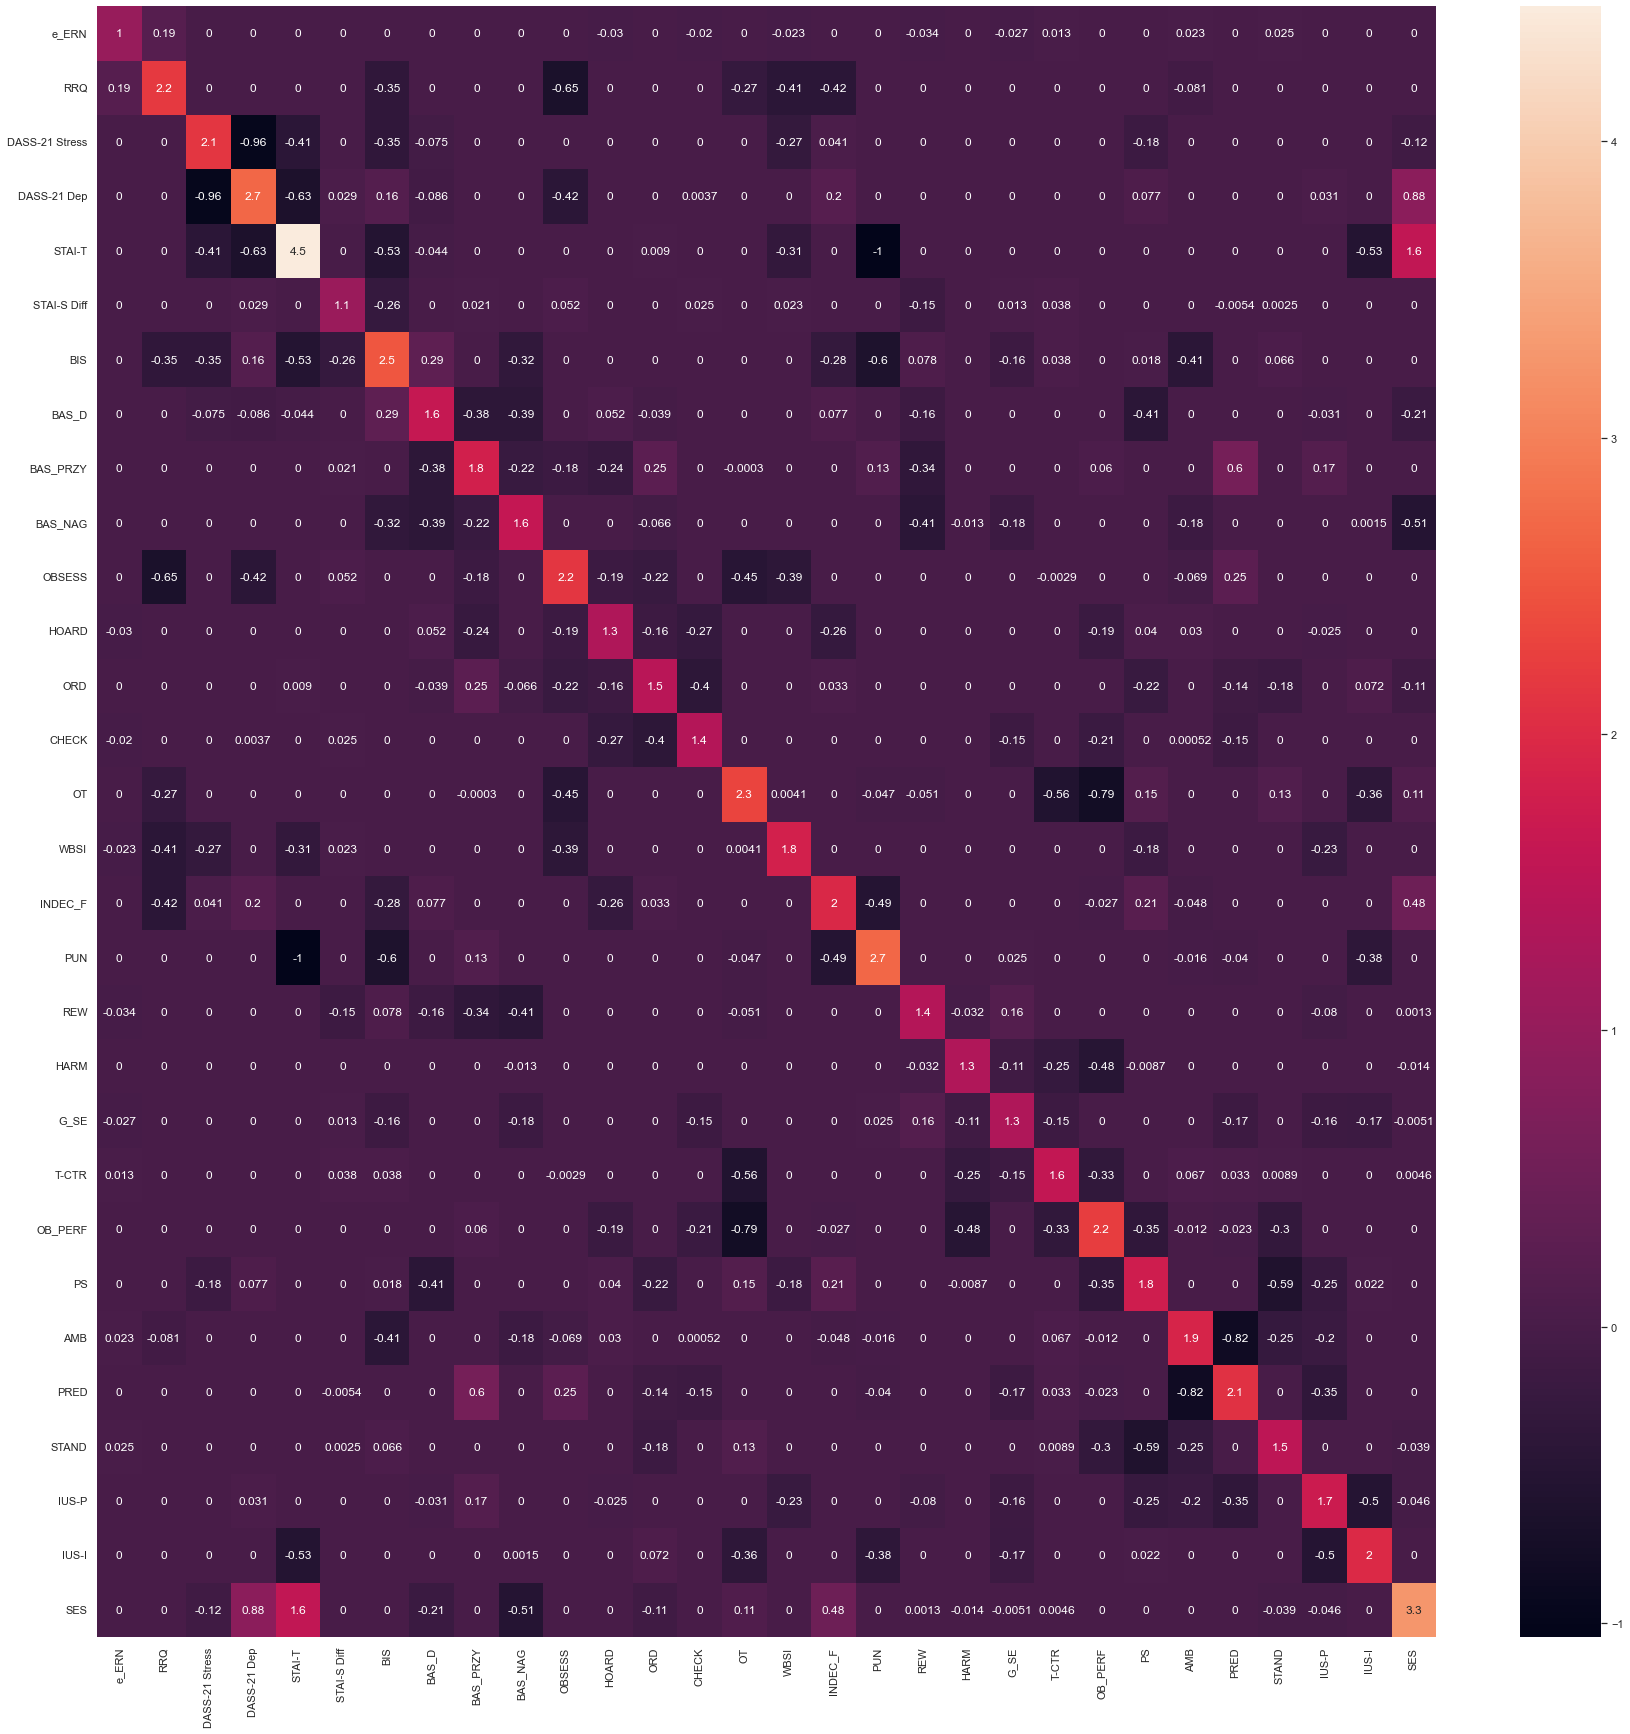

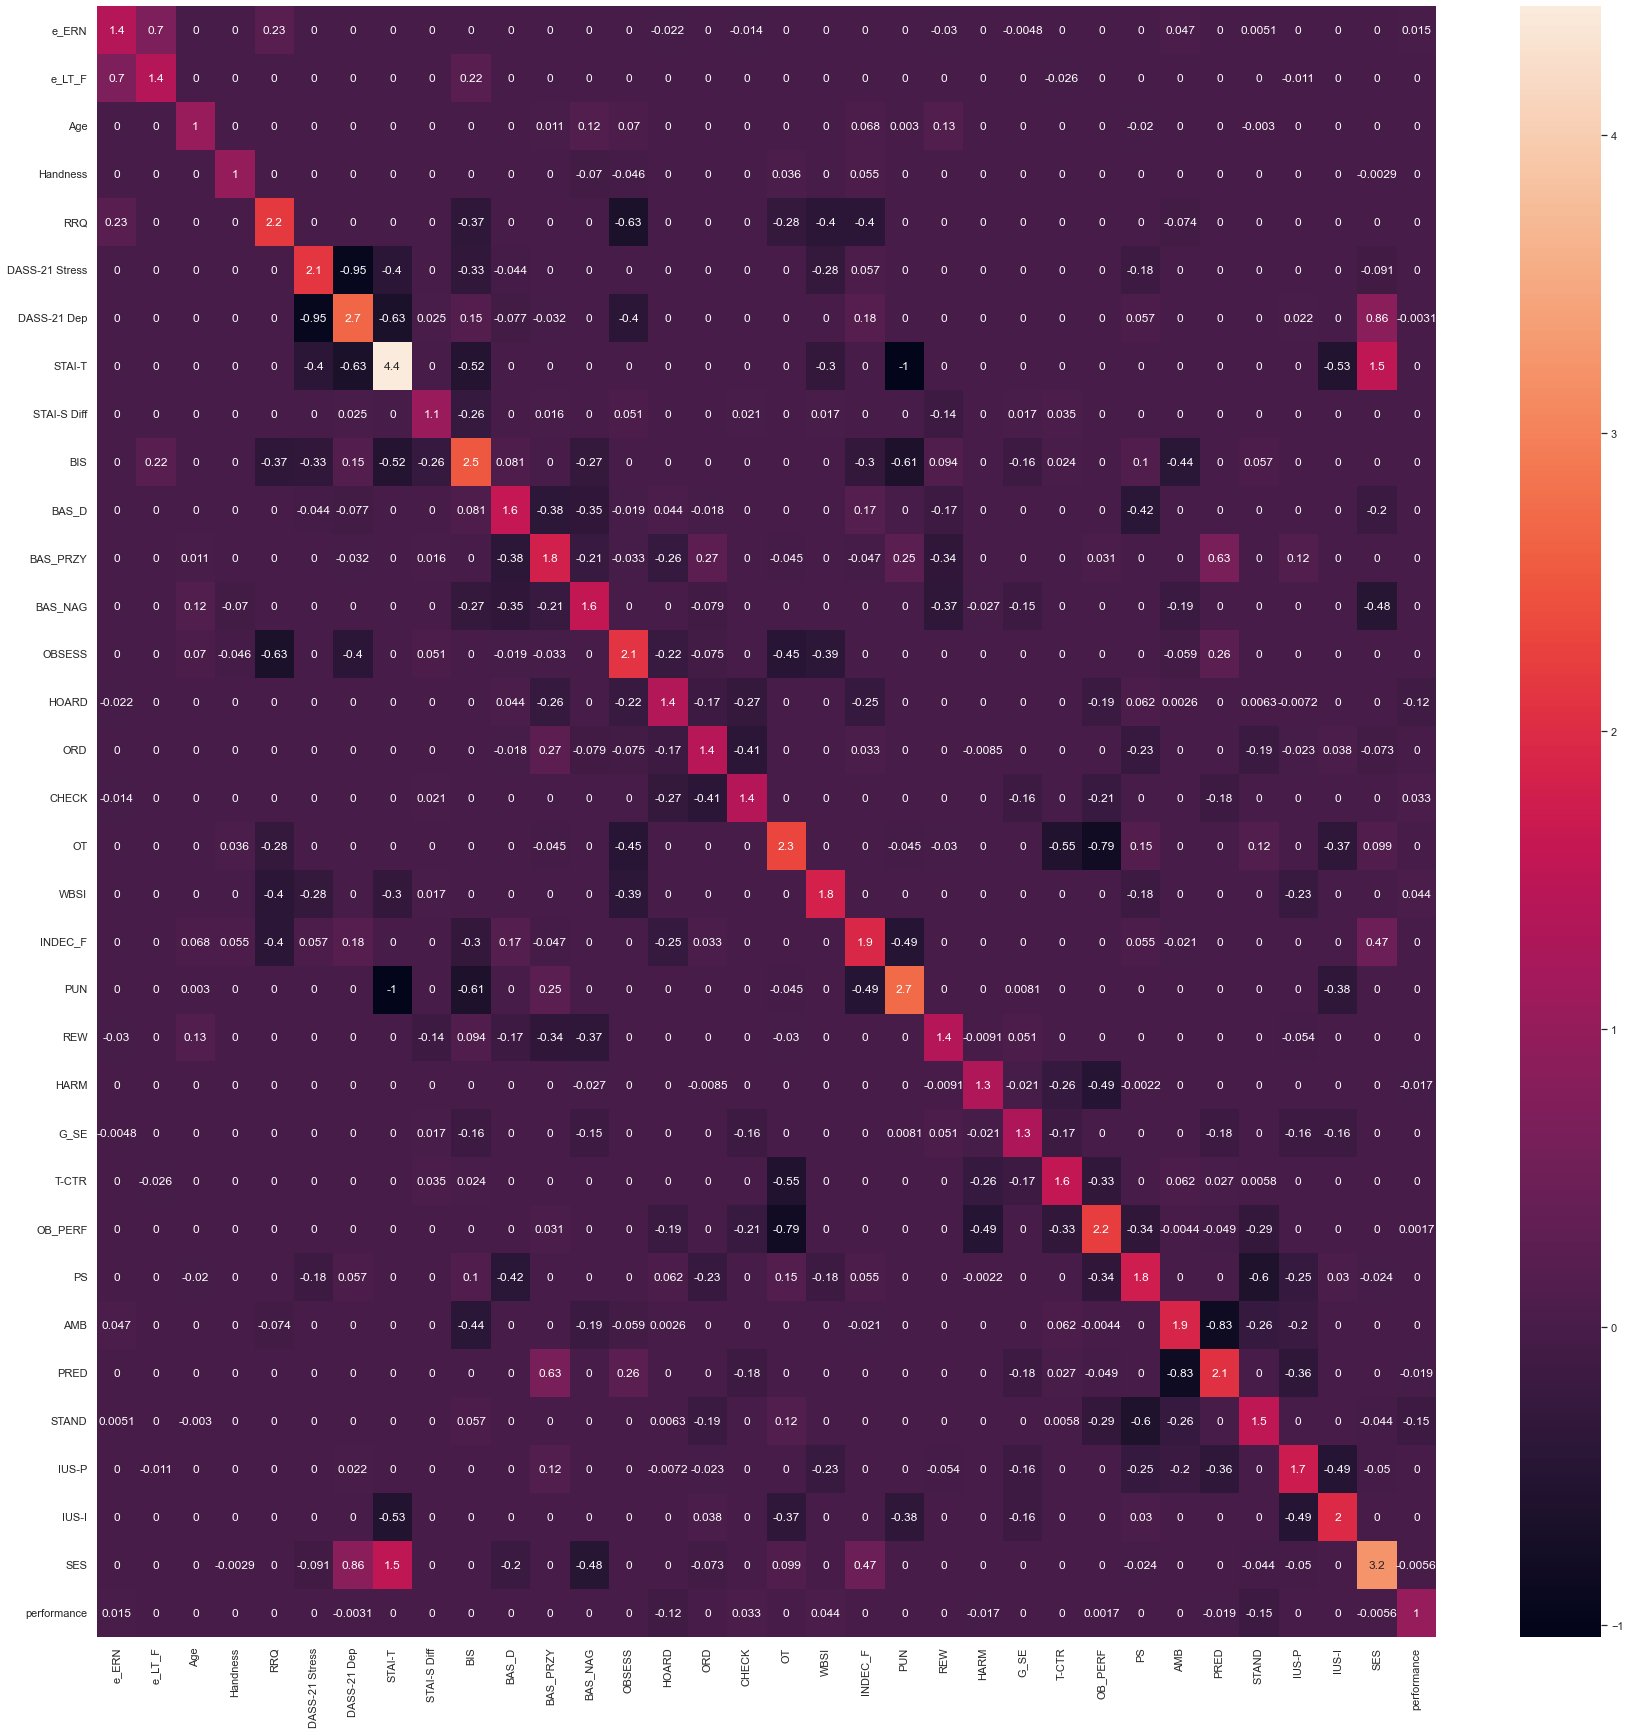

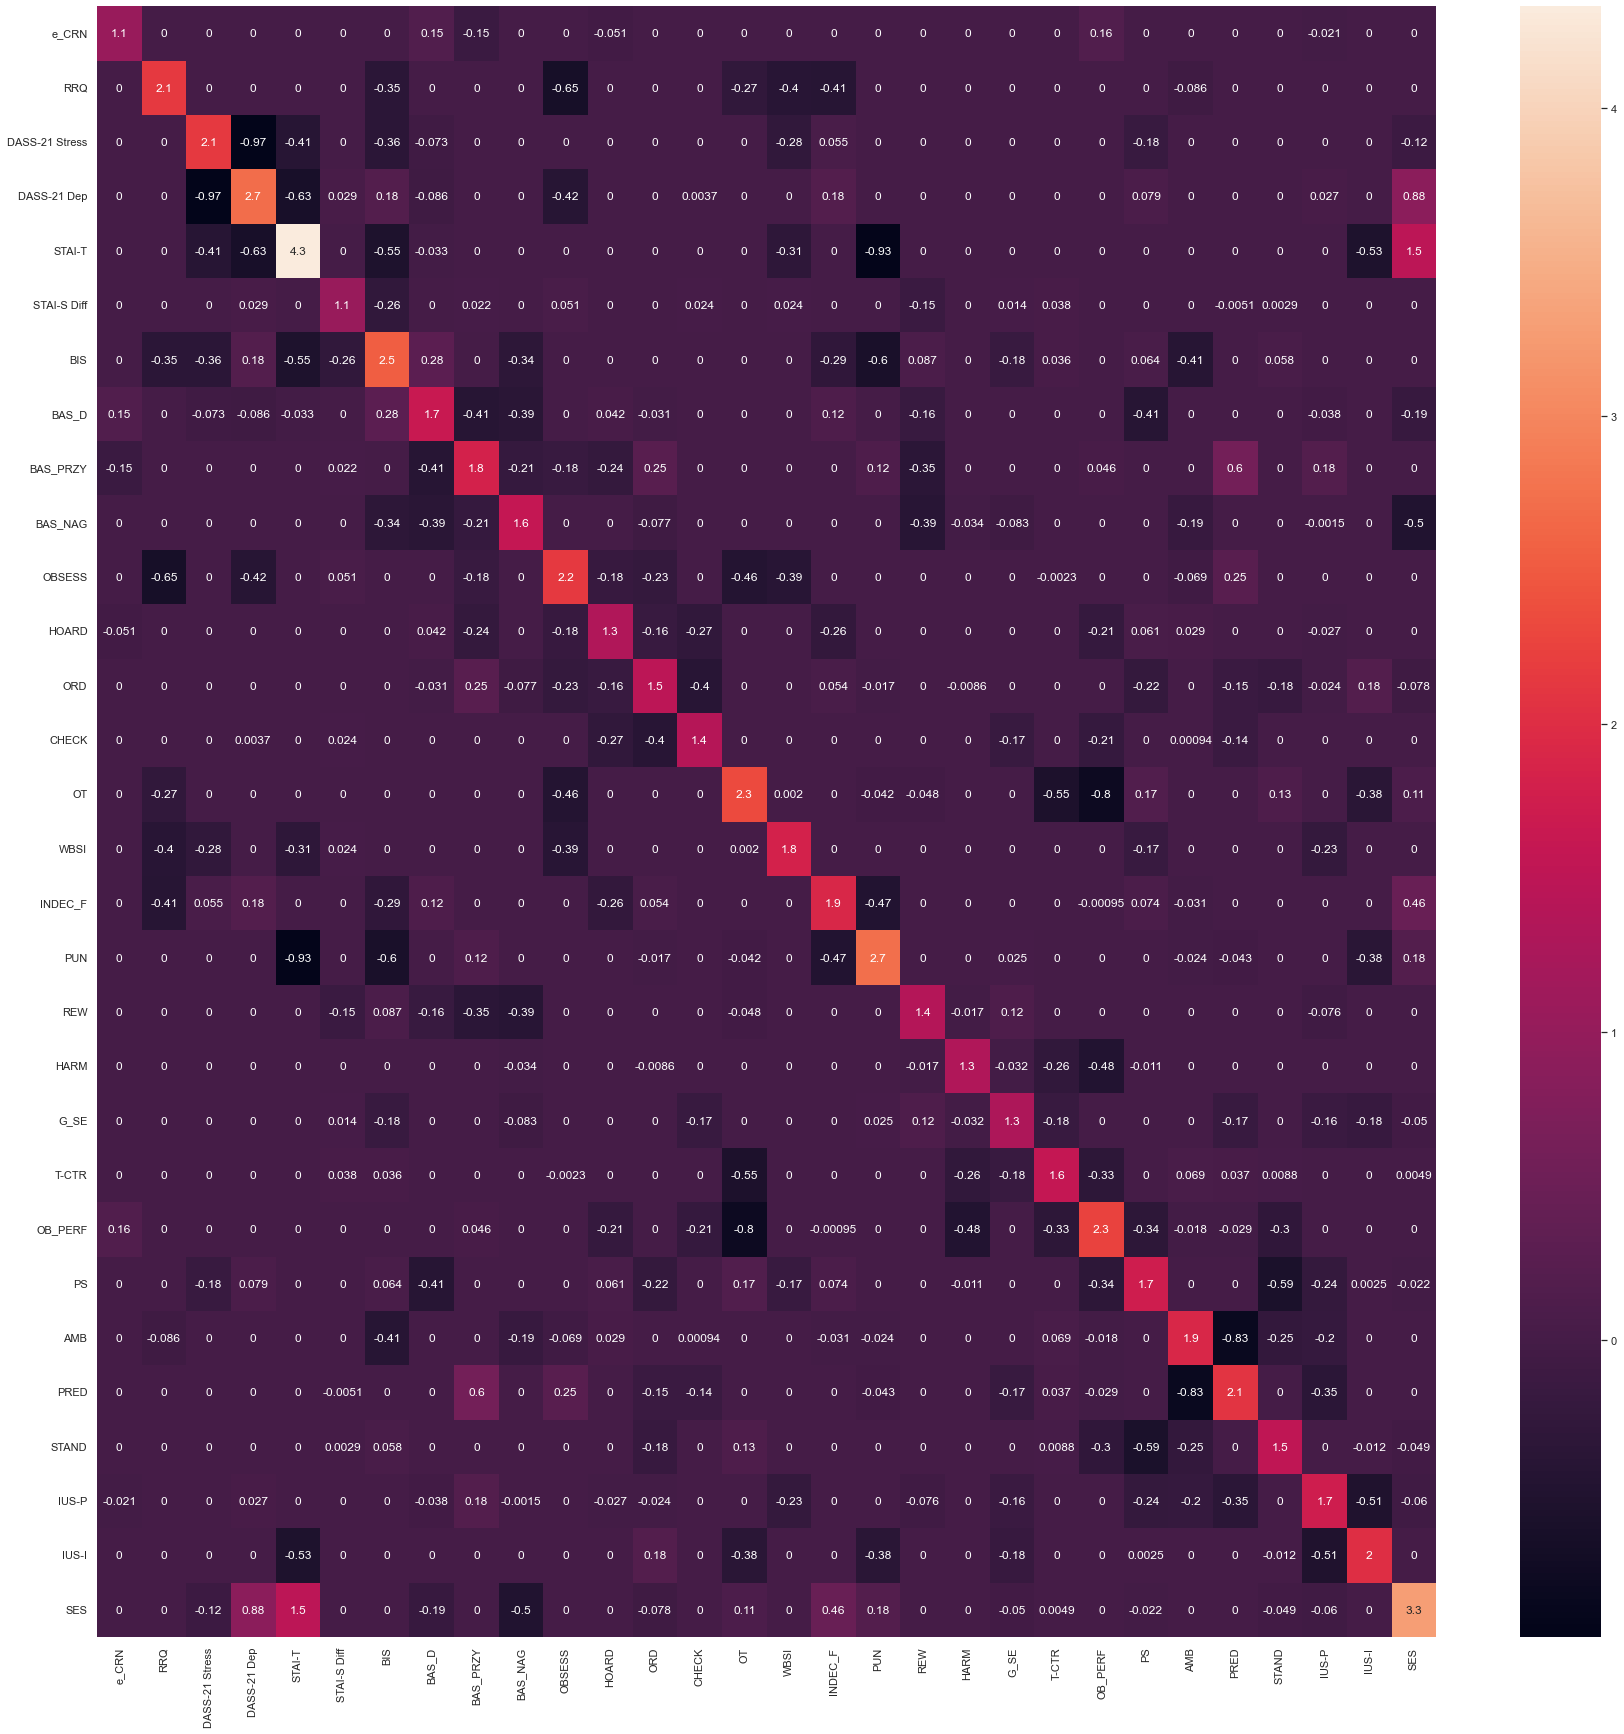

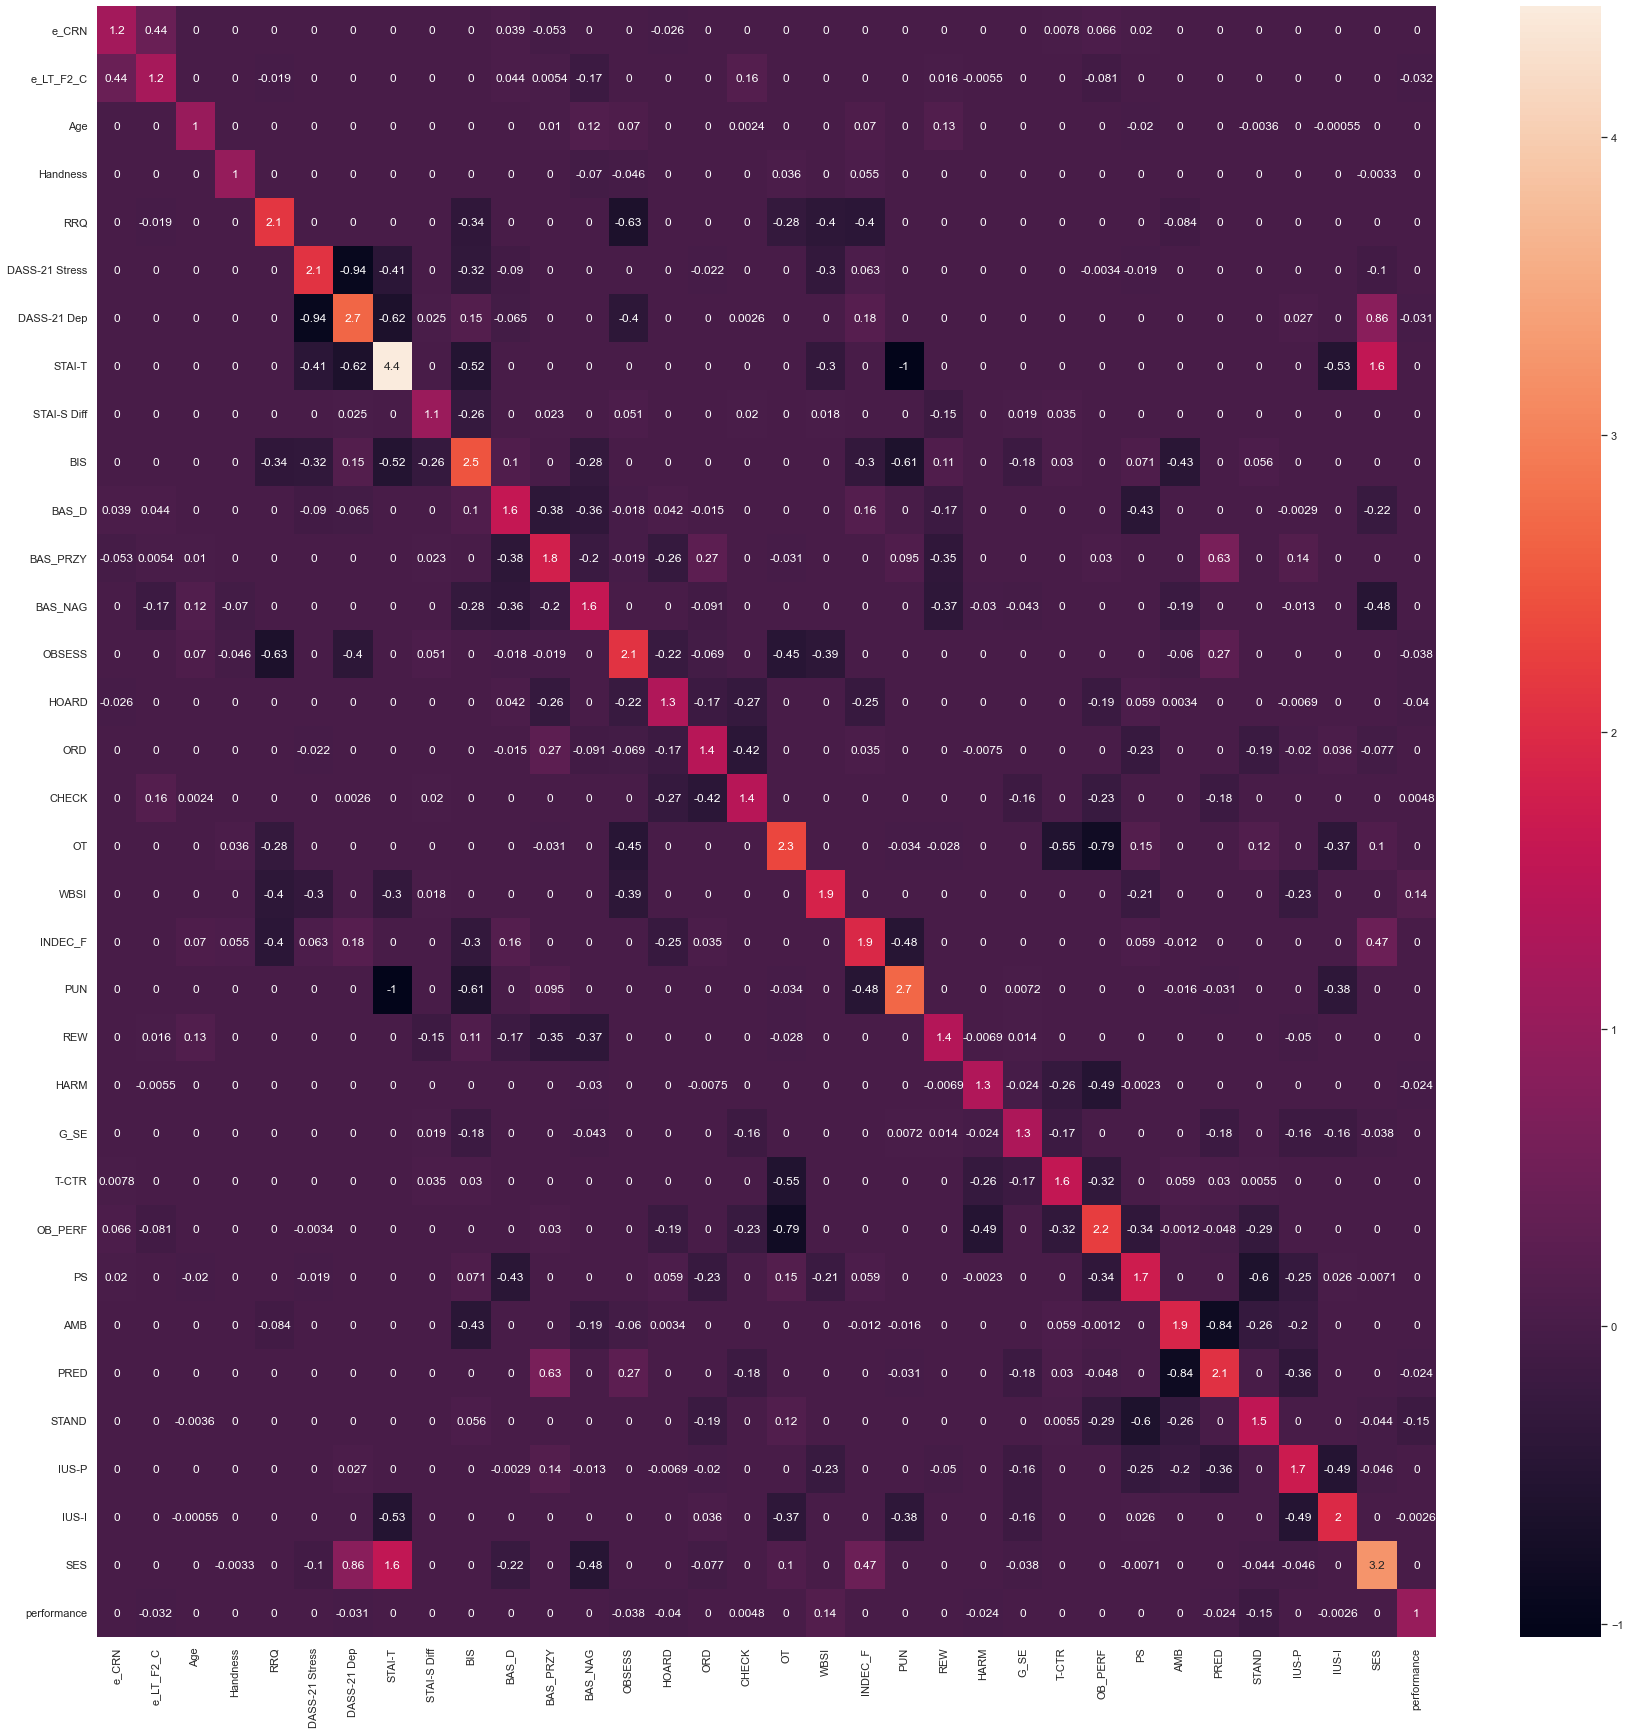

In [25]:
sns.set(rc={'figure.figsize':(30 , 30)})

for i, matrix in enumerate(precision_matrixes):
    plt.figure(i)
    sns.heatmap(
        data = matrix,
        annot=True        
    )

##### Test

In [17]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# for i, matrix in enumerate(precision_matrixes_test):
#     plt.figure(i)
#     sns.heatmap(
#         data = matrix,
#         annot=True        
#     )

---
## Calculate nodes predictability

In [7]:
def calculate_nodes_predictability(X, precision_matrix_df, threshold=0.02):
    precision_matrix_df_mask = precision_matrix_df.mask(abs(precision_matrix_df) <= threshold, False)
    precision_matrix_df_mask = precision_matrix_df_mask.mask(abs(precision_matrix_df_mask) > threshold, True)
    
    np.fill_diagonal(precision_matrix_df_mask.values, False)

    explained_variance = []

    for node in precision_matrix_df_mask.columns:
        mask = precision_matrix_df_mask.loc[node].to_numpy()
        masked_colums = precision_matrix_df_mask.columns[mask]    
        y_ = X[[node]]
        # display(y)

        X_ = X[masked_colums]
        # display(X)

        lm = LinearRegression()
        lm.fit(X_, y_)

        score = lm.score(X_,y_)
        # print(f"Score for node {node}: {score}\n")
        explained_variance.append(score)


    explained_variance_df = pd.DataFrame(np.array(explained_variance).reshape(1,-1), columns=precision_matrix_df.columns)
    return explained_variance_df

Calculate nodes predictabilities for models

In [8]:
ern_precision = precision_matrixes[0]
ern_precision_cov = precision_matrixes[1]
crn_precision = precision_matrixes[2]
crn_precision_cov = precision_matrixes[3]

X_ern = results_ern_df
X_ern_cov = results_ern_lat_demo_df
X_crn = results_crn_df
X_crn_cov = results_crn_lat_demo_df

In [9]:
ern_predictability = calculate_nodes_predictability(X_ern, ern_precision)
ern_cov_predictability = calculate_nodes_predictability(X_ern_cov, ern_precision_cov)
crn_predictability = calculate_nodes_predictability(X_crn, crn_precision)
crn_cov_predictability = calculate_nodes_predictability(X_crn_cov, crn_precision_cov)

In [10]:
ern_predictability.to_dict('records')[0]

{'e_ERN': 0.06738962019783712,
 'RRQ': 0.5522955416517236,
 'DASS-21 Stress': 0.5796427065974279,
 'DASS-21 Dep': 0.6717273206902072,
 'STAI-T': 0.7810898425128681,
 'STAI-S Diff': 0.09359885128873724,
 'BIS': 0.6255911904221434,
 'BAS_D': 0.41349026683251655,
 'BAS_PRZY': 0.473136922692315,
 'BAS_NAG': 0.4135093791374679,
 'OBSESS': 0.5520798691680742,
 'HOARD': 0.28886384154637734,
 'ORD': 0.3582918580710628,
 'CHECK': 0.28875463431244364,
 'OT': 0.5986283948248731,
 'WBSI': 0.46218292868501254,
 'INDEC_F': 0.49638489596323165,
 'PUN': 0.6531423134960807,
 'REW': 0.31197830401716764,
 'HARM': 0.2670299143867054,
 'G_SE': 0.28545271197747824,
 'T-CTR': 0.39086488628807414,
 'OB_PERF': 0.5779823834437566,
 'PS': 0.4332763184186682,
 'AMB': 0.49546592826867963,
 'PRED': 0.5301233368448965,
 'STAND': 0.3595325285832953,
 'IUS-P': 0.4379577139753038,
 'IUS-I': 0.5127641514169237,
 'SES': 0.718992295449242}

## Visualize ERN and CRN graphs

#### Extract list of links from precision matrices

In [11]:
def get_links(precision_matrix_df, threshold=0.02):
    #prepare the matrix for network illustration
    precision_matrix_df = precision_matrix_df.where(np.triu(np.ones(precision_matrix_df.shape)).astype(np.bool))

    links = precision_matrix_df.stack().reset_index()
    links.columns = ['var1', 'var2','weight']
    links=links.loc[ (abs(links['weight']) > threshold) &  (links['var1'] != links['var2']) ]
    
    # remove links between EEG features for clarity
    # links = links[~((links['var1'].str.contains("e_")) & (links['var2'].str.contains("e_")))]
    
    links = links.round(3)
    
    return links

In [12]:
test

False

In [13]:
if test:
    test_links = []

    for matrix in precision_matrixes_test:
        this_links = get_links(matrix)
        test_links.append(this_links)
else:
    links = []

    for matrix in precision_matrixes:
        this_links = get_links(matrix)
        links.append(this_links)

Leave only N leafs from parent (eeg) nodes

In [14]:
def leave_n_edges_from_eeg(links, N=2):
    parents = set(links[links['var1'].str.contains("e_ERN") | links['var1'].str.contains("e_CRN")]['var1'])

    final_edges = []
    edges_df = pd.DataFrame({})
    leafs = set()

    for parent in parents:
        this_leafs = []

        parent_edges = links[links['var1'] == parent]
        final_edges.append(parent_edges)
        leafs.update(parent_edges['var2'])


    for i in range(1,N+1):
        parents = leafs
        leafs = set()

        for parent in parents:
            parent_edges = links[(links['var1'] == parent) | (links['var2'] == parent)]

            final_edges.append(parent_edges)
            leafs.update(parent_edges['var2'])
            leafs.update(parent_edges['var1'])

    edges_df = pd.concat(final_edges, axis=0, ignore_index=True)
    edges_df = edges_df.drop_duplicates(subset = ["var1", 'var2'])
    
    return edges_df

#### Bulid the graph from the links

Node labels mappers

In [15]:
mapping_ern = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    # "OCI-R": "11Q",
    "WBSI": "11Q",
    "IUS-P": "12Q",
    "IUS-I": "13Q",
    "SES": "14Q",
    'BAS_D': "15Q",
    'BAS_PRZY': "16Q",
    'BAS_NAG': "17Q",
    'INDEC_F': "18Q",
    'PUN': "19Q",
    'REW': "20Q",
    'HARM': "21Q",
    'T-CTR': "22Q",
    "OT": "23Q",
    'OB_PERF': "24Q",
    # 'CMDA': "25Q",
    'PS': "25Q",
    'G_SE': "26Q",
    'AMB': "27Q",
    'PRED': "28Q",
    'STAND': "29Q",   
    "Age": "1C",
    # "Sex": "2C",
    "Handness": "2C",
    'e_ERN': "1E",
    'e_LT_F': "3C",
    'performance': "4C",
}

mapping_crn = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    # "OCI-R": "11Q",
    "WBSI": "11Q",
    "IUS-P": "12Q",
    "IUS-I": "13Q",
    "SES": "14Q",
    'BAS_D': "15Q",
    'BAS_PRZY': "16Q",
    'BAS_NAG': "17Q",
    'INDEC_F': "18Q",
    'PUN': "19Q",
    'REW': "20Q",
    'HARM': "21Q",
    'T-CTR': "22Q",
    "OT": "23Q",
    'OB_PERF': "24Q",
    # 'CMDA': "25Q",
    'PS': "25Q",
    'G_SE': "26Q",
    'AMB': "27Q",
    'PRED': "28Q",
    'STAND': "29Q",   
    "Age": "1C",
    # "Sex": "2C",
    "Handness": "2C",
    'e_CRN': "2E",
    'e_LT_F2_C': "3C",
    'performance': "4C",
}

In [16]:
def draw_graph(links, basic_links=None, basic=False, mapping=mapping_ern, seed=1, nodes_predictabilities=None, scale=1, specific_positions = []):
    
    cm = 1/2.54
    dpi = 500

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    sns.set_style("white")
    
    palette = sns.color_palette("colorblind")
    
          
    fig = plt.figure(3, figsize=(10*cm, 10*cm))
    
    ax = fig.add_axes([0,0,1,1], aspect=1)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    
    # create graph
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    
    # set nodes colors
    node_color=[palette[0] if node.find('Q') != -1 
                else palette[1]if node.find('E') != -1 
                else palette[2] for node in G.nodes()]
    # set nodes position
    edges = G.edges() 
    
    for u,v in edges:
        G[u][v]['weight'] = abs(G[u][v]['weight'])
        # print(f"{u},{v},{G[u][v]['weight']}")
    
    pos_i = nx.spring_layout(G, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=scale, seed=seed)
    pos = pos_i
    # pos = nx.kamada_kawai_layout(G, pos=pos_i, scale=1)
    
    for position in specific_positions:
        pos[position[0]] = position[1]
    
    # drawing all links
    if basic is False:
        G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
        G = nx.relabel_nodes(G, mapping)
        
        edges = G.edges() 
           
        weights = []
        for u,v in edges:
            weight = G[u][v]['weight']
            # print(f"{u},{v},{weight}")
            weights.append(weight)
            
        edge_color = [('red' if edge < 0 else 'blue') for edge in weights]

        weights_alphas = []
        weight_bold = []

        for edge_weight in weights:
            if abs(edge_weight) < 0.05:
                alpha = 0.2 
                bold = 1
            elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.1:
                alpha = 0.25
                bold = 1
            elif abs(edge_weight) >= 0.1 and abs(edge_weight) < 0.15:
                alpha = 0.3
                bold = 2
            elif abs(edge_weight) >= 0.15 and abs(edge_weight) < 0.2:
                alpha = 0.35
                bold = 1
            elif abs(edge_weight) >= 0.15 and abs(edge_weight) < 0.2:
                alpha = 0.38
                bold = 1
            elif abs(edge_weight) >= 0.2 and abs(edge_weight) < 0.25:
                alpha = 0.40
                bold = 1
            elif abs(edge_weight) >= 0.25 and abs(edge_weight) < 0.3:
                alpha = 0.42
                bold = 1
            elif abs(edge_weight) >= 0.3 and abs(edge_weight) < 0.35:
                alpha = 0.45
                bold = 1
            else:
                alpha = 0.5
                bold = 1
            weights_alphas.append(alpha)
            weight_bold.append(bold)

    # drawing EEG links 'first' || 'only'
    if (basic is not False):
        G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
        G = nx.relabel_nodes(G, mapping)
        
        edges = G.edges() 
           
        weights = []
        for u,v in edges:
            weight = G[u][v]['weight']
            # print(f"{u},{v},{weight}")
            weights.append(weight)
            
        edge_color = [('red' if edge < 0 else 'blue') for edge in weights]
        
        weights_alphas = []
        weight_bold = []

        for edge_weight in weights:
            alpha = 0.15 
            bold = 1
            weights_alphas.append(alpha)
            weight_bold.append(bold)
            
        ###########################################################################################################
        G_eeg = nx.from_pandas_edgelist(basic_links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
        G_eeg = nx.relabel_nodes(G_eeg, mapping)
        
        eeg_edges = G_eeg.edges() 
        
        weights_eeg = []
        for u,v in eeg_edges:
            weight = G_eeg[u][v]['weight']
            print(f"{u},{v},{weight}")
            weights_eeg.append(weight)
            
        # edges_eeg_list = list(zip(basic_links.var1.to_list(), basic_links.var2.to_list()))
        edge_eeg_color = [('red' if edge < 0 else 'blue') for edge in weights_eeg]
        
        # weights_eeg = basic_links.weight.to_list()
        weights_eeg_alphas = []
        weights_eeg_bold = []

        for edge_weight in weights_eeg:
            if abs(edge_weight) < 0.05:
                alpha = 0.3 
                bold = 2
            elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.09:
                alpha = 0.35
                bold = 2
            elif abs(edge_weight) >= 0.09 and abs(edge_weight) < 0.16:
                alpha = 0.40
                bold = 3
            elif abs(edge_weight) >= 0.16 and abs(edge_weight) < 0.5:
                alpha = 0.45
                bold = 3
            else:
                alpha = 0.6
                bold = 3
            weights_eeg_alphas.append(alpha)
            weights_eeg_bold.append(bold)
            
        
    nx.draw_networkx_nodes(
        G, 
        pos=pos,
        linewidths=0.5,
        edgecolors='black',
        node_size = 190,
        node_color=node_color,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=7,
    )
    
    if basic == False:
        nx.draw_networkx_edges(
            G, 
            pos=pos,
            edgelist = G.edges(),
            edge_color = edge_color,
            alpha=weights_alphas,
            width = weight_bold,
        )
        

    if basic_links is not None and basic == 'only':
        nx.draw_networkx_edges(
            G, 
            pos=pos,
            edgelist = G_eeg.edges(),
            edge_color = edge_eeg_color,
            alpha=weights_eeg_alphas,
            width = weights_eeg_bold,
        )
    
    if basic_links is not None and basic == 'first':
        nx.draw_networkx_edges(
            G, 
            pos=pos,
            edgelist = G.edges(),
            edge_color = edge_color,
            alpha=weights_alphas,
            width = weight_bold,
        )
        
        nx.draw_networkx_edges(
            G, 
            pos=pos,
            edgelist = G_eeg.edges(),
            edge_color = edge_eeg_color,
            alpha=weights_eeg_alphas,
            width = weights_eeg_bold,
        )
    
    # add nodes predictabilities
    if nodes_predictabilities is not None:
        nodes_predictabilities = nodes_predictabilities.rename(columns=mapping)

        patches = []
        colors = []
        for item in pos.items():
            node_id = item[0]
            # print(node_id)
            node_predictability = nodes_predictabilities[node_id].to_list()[0]
            node_predictability_percent = 360 * node_predictability
            # print(node_predictability_percent)
            cor_x, cor_y = item[1]

            weg_bck = Wedge((cor_x, cor_y), .060, 0, 360, width=0.03, edgecolor='black', linewidth=0.3, facecolor='white')
            patches.append(weg_bck)
            colors.append(0)
            ax.add_patch(weg_bck)

            weg = Wedge((cor_x, cor_y), .060, 0, node_predictability_percent, width=0.03, edgecolor='black', linewidth=0.3, facecolor='gray')
            patches.append(weg)
            colors.append(1)
            ax.add_patch(weg)
        

    # p = PatchCollection(patches, edgecolor='black', linewidth=0.3)
    # print(100 * np.random.rand(len(patches)))
    # p.set_array(colors)
    # ax.add_collection(p)   
        
    

    plt.show()   

##### Train links

- ERN graph

Draw graph


In [17]:
positions = [
    ('21Q', [0.85, 0.4]),
    ('1E', [0.2, -0.75])
]

1E,1Q,0.194
1E,8Q,-0.03
1E,11Q,-0.023
1E,20Q,-0.034
1E,26Q,-0.027
1E,27Q,0.023
1E,29Q,0.025


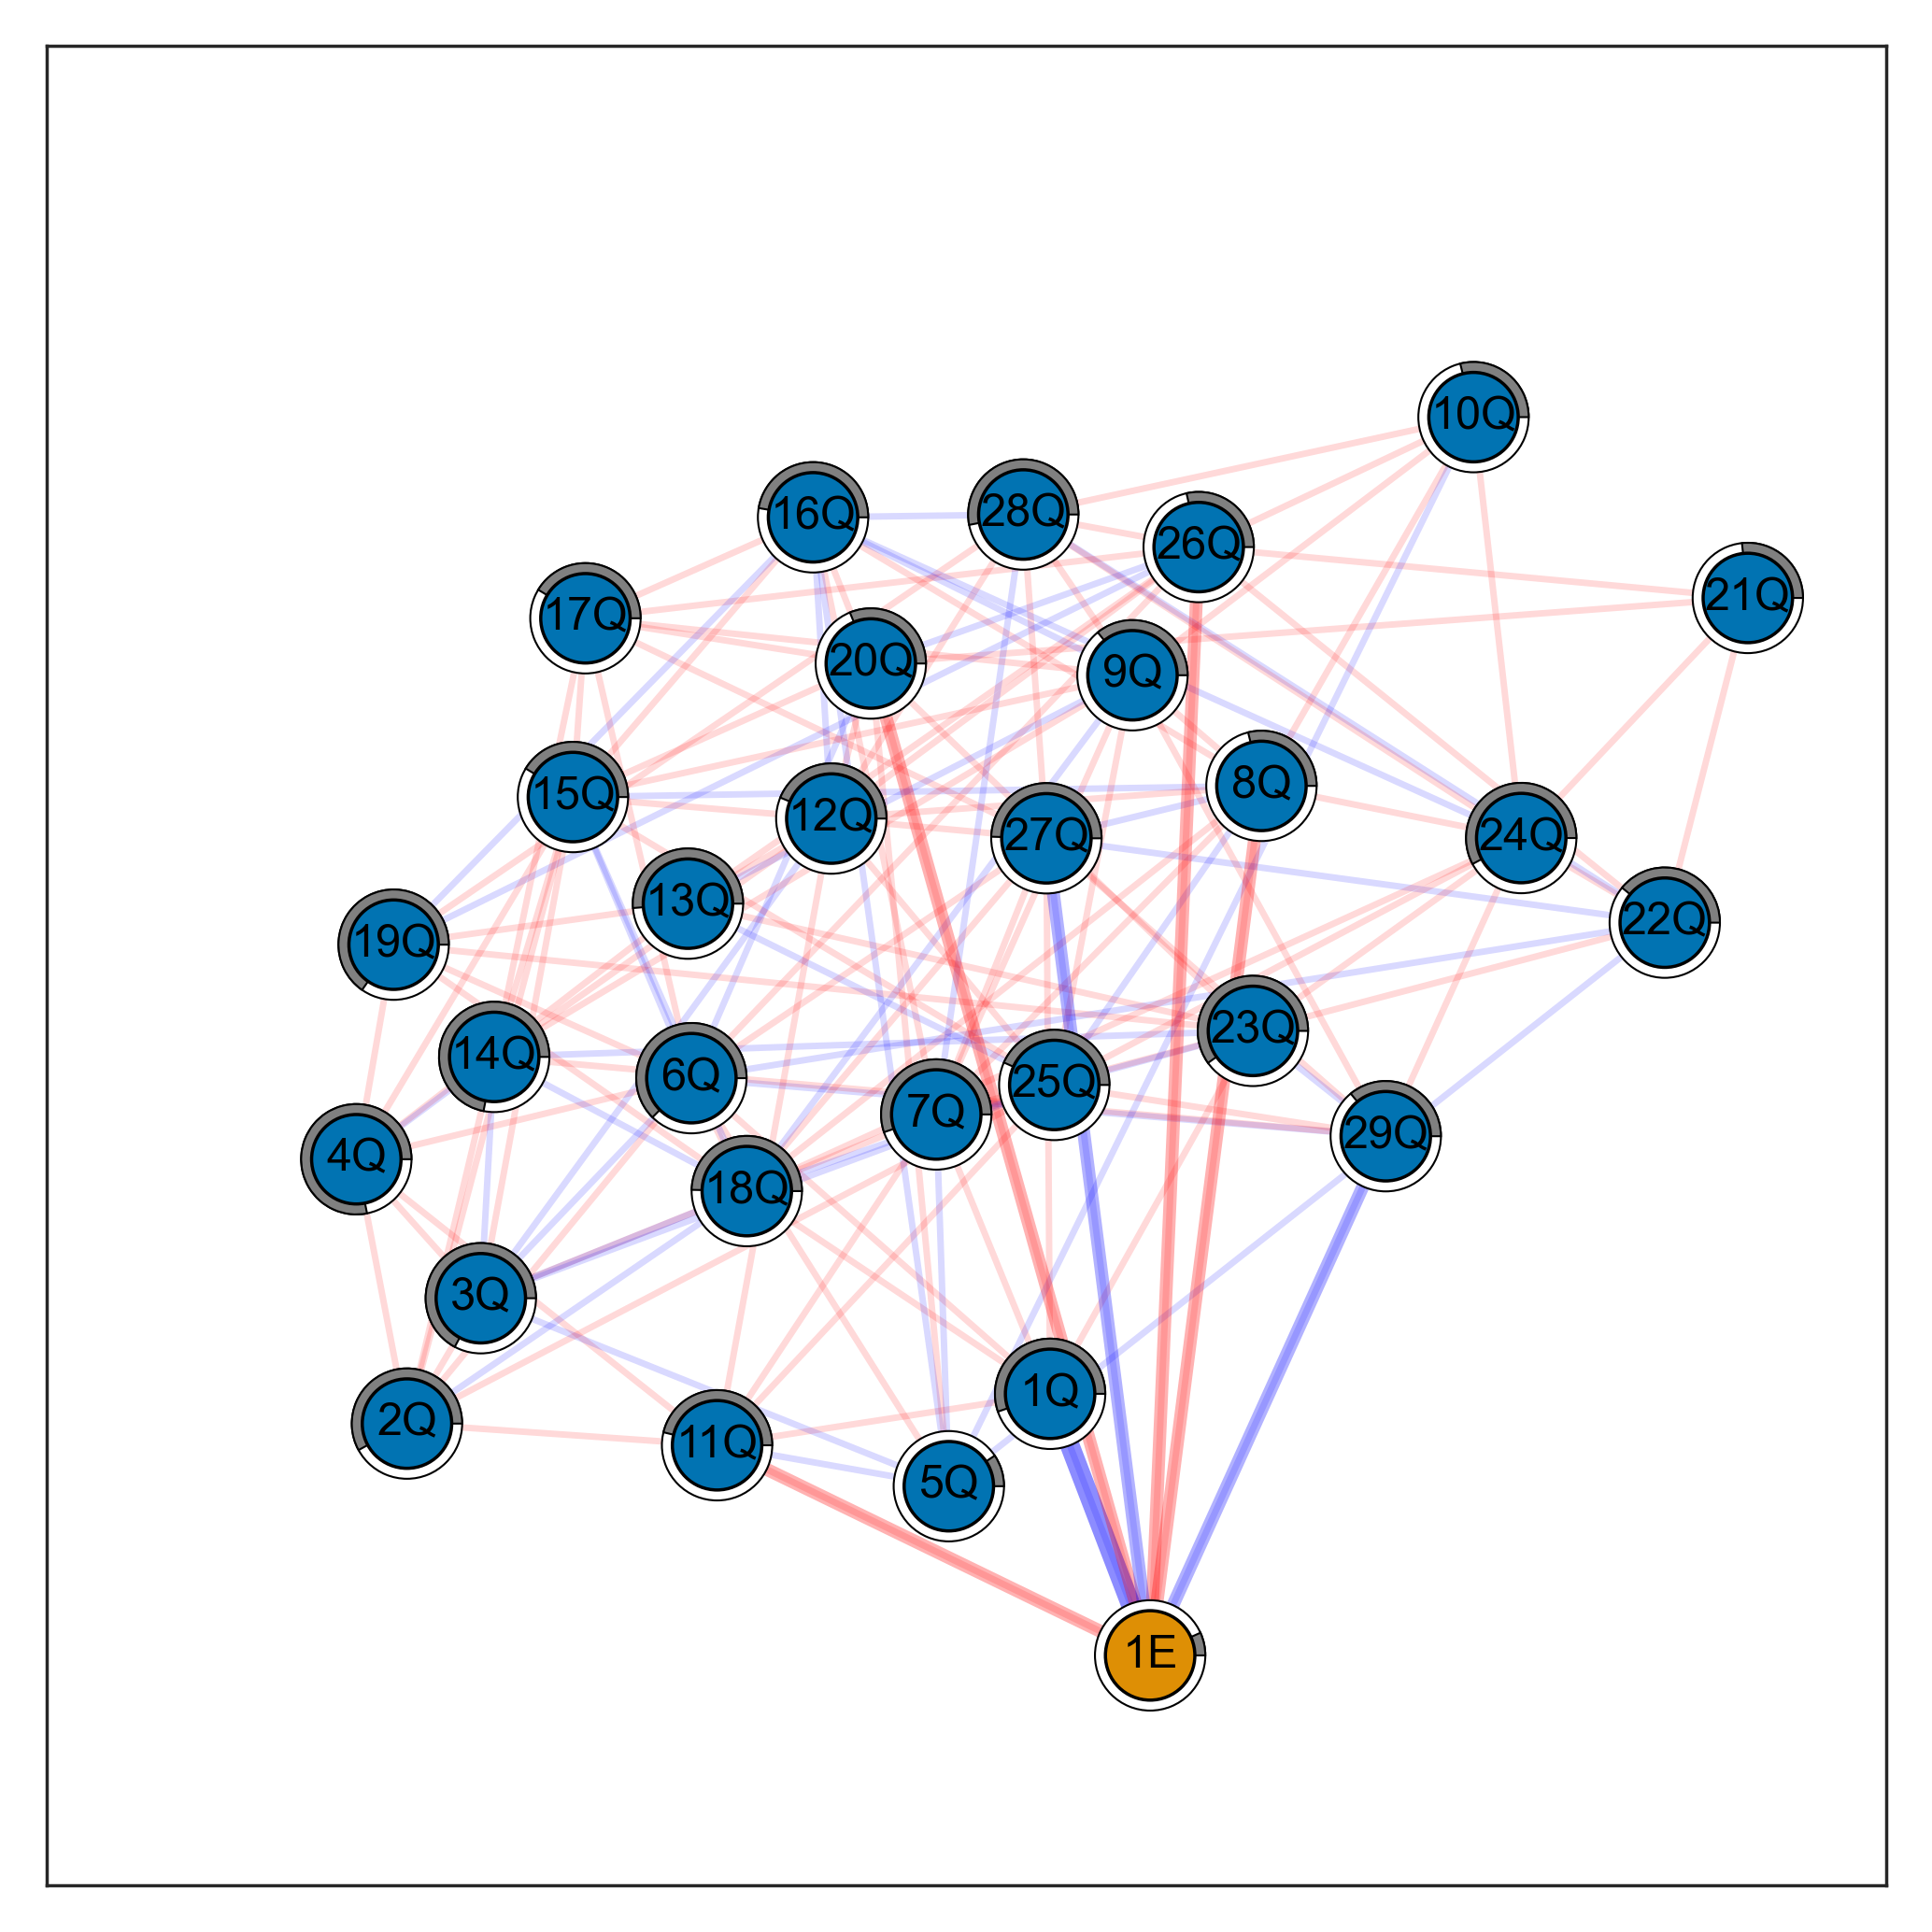

In [19]:
draw_graph(
    links[0], 
    seed=13, 
    basic_links=leave_n_edges_from_eeg(links[0], N=0),
    basic='first', 
    nodes_predictabilities = ern_predictability,
    specific_positions=positions,
) 

In [23]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None):
    display(links[0].sort_values('var1'))

var1         var2  weight
447             AMB        IUS-P  -0.204
446             AMB        STAND  -0.253
445             AMB         PRED  -0.825
211           BAS_D          SES  -0.205
209           BAS_D        IUS-P  -0.031
205           BAS_D           PS  -0.406
200           BAS_D          REW  -0.164
198           BAS_D      INDEC_F   0.077
194           BAS_D          ORD  -0.039
193           BAS_D        HOARD   0.052
191           BAS_D      BAS_NAG  -0.385
190           BAS_D     BAS_PRZY  -0.382
237         BAS_NAG          ORD  -0.066
243         BAS_NAG          REW  -0.407
254         BAS_NAG          SES  -0.505
245         BAS_NAG         G_SE  -0.181
249         BAS_NAG          AMB  -0.182
216        BAS_PRZY          ORD   0.247
231        BAS_PRZY        IUS-P   0.173
229        BAS_PRZY         PRED   0.598
226        BAS_PRZY      OB_PERF   0.060
213        BAS_PRZY      BAS_NAG  -0.217
214        BAS_PRZY       OBSESS  -0.180
215        BAS_PRZY        HOARD  -0.241
222        BAS_PRZY          REW  -0.343
221        BAS_PRZY          PUN   0.130
176             BIS          PUN  -0.602
180             BIS        T-CTR   0.038
168             BIS      BAS_NAG  -0.320
166             BIS        BAS_D   0.290
183             BIS          AMB  -0.411
185             BIS        STAND   0.066
175             BIS      INDEC_F  -0.283
177             BIS          REW   0.078
179             BIS         G_SE  -0.161
324           CHECK         PRED  -0.148
321           CHECK      OB_PERF  -0.209
319           CHECK         G_SE  -0.154
113     DASS-21 Dep          SES   0.885
111     DASS-21 Dep        IUS-P   0.031
107     DASS-21 Dep           PS   0.077
100     DASS-21 Dep      INDEC_F   0.197
94      DASS-21 Dep       OBSESS  -0.419
91      DASS-21 Dep        BAS_D  -0.086
90      DASS-21 Dep          BIS   0.163
89      DASS-21 Dep  STAI-S Diff   0.029
88      DASS-21 Dep       STAI-T  -0.633
60   DASS-21 Stress  DASS-21 Dep  -0.963
61   DASS-21 Stress       STAI-T  -0.409
72   DASS-21 Stress         WBSI  -0.274
73   DASS-21 Stress      INDEC_F   0.041
80   DASS-21 Stress           PS  -0.176
86   DASS-21 Stress          SES  -0.117
64   DASS-21 Stress        BAS_D  -0.075
63   DASS-21 Stress          BIS  -0.349
418            G_SE        IUS-I  -0.168
417            G_SE        IUS-P  -0.159
411            G_SE        T-CTR  -0.150
415            G_SE         PRED  -0.165
400            HARM         G_SE  -0.113
401            HARM        T-CTR  -0.255
402            HARM      OB_PERF  -0.480
276           HOARD          ORD  -0.156
287           HOARD           PS   0.040
286           HOARD      OB_PERF  -0.194
280           HOARD      INDEC_F  -0.257
277           HOARD        CHECK  -0.270
288           HOARD          AMB   0.030
291           HOARD        IUS-P  -0.025
361         INDEC_F          PUN  -0.491
366         INDEC_F      OB_PERF  -0.027
367         INDEC_F           PS   0.209
373         INDEC_F          SES   0.485
368         INDEC_F          AMB  -0.048
461           IUS-P          SES  -0.046
460           IUS-P        IUS-I  -0.496
256          OBSESS        HOARD  -0.186
257          OBSESS          ORD  -0.220
259          OBSESS           OT  -0.454
260          OBSESS         WBSI  -0.389
269          OBSESS          AMB  -0.069
270          OBSESS         PRED   0.251
433         OB_PERF        STAND  -0.301
430         OB_PERF           PS  -0.353
432         OB_PERF         PRED  -0.023
308             ORD        STAND  -0.183
311             ORD          SES  -0.108
295             ORD        CHECK  -0.400
298             ORD      INDEC_F   0.033
305             ORD           PS  -0.220
307             ORD         PRED  -0.141
310             ORD        IUS-I   0.072
337              OT      OB_PERF  -0.789
338              OT           PS   0.155
343              OT        IUS-I  -0.363
336              OT        T-CTR  -0.556
344              OT          SES   0.1

Display the predictability of nodes

In [77]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_predictability)

e_ERN       RRQ  DASS-21 Stress  DASS-21 Dep   STAI-T  STAI-S Diff  \
0  0.06739  0.552296        0.579643     0.671727  0.78109     0.093599   

        BIS    BAS_D  BAS_PRZY   BAS_NAG   OBSESS     HOARD       ORD  \
0  0.625591  0.41349  0.473137  0.413509  0.55208  0.288864  0.358292   

      CHECK        OT      WBSI   INDEC_F       PUN       REW     HARM  \
0  0.288755  0.598628  0.462183  0.496385  0.653142  0.311978  0.26703   

       G_SE     T-CTR   OB_PERF        PS       AMB      PRED     STAND  \
0  0.285453  0.390865  0.577982  0.433276  0.495466  0.530123  0.359533   

      IUS-P     IUS-I       SES  
0  0.437958  0.512764  0.718992

Save graph

In [78]:
G_ = nx.from_pandas_edgelist(links[0],'var1','var2', edge_attr='weight', create_using=nx.Graph())
nx.write_gml(G_, '../data/graphs/ern_graph.gml')

- ERN cov graph

Draw graph


In [20]:
positions = [
    ('2C', [0.2, -0.75]),
    ('4C', [-0.6, 0.7]),
    ('21Q', [-0.8, -0.2])

]

1E,3C,0.697
1E,1Q,0.226
1E,8Q,-0.022
1E,20Q,-0.03
1E,27Q,0.047


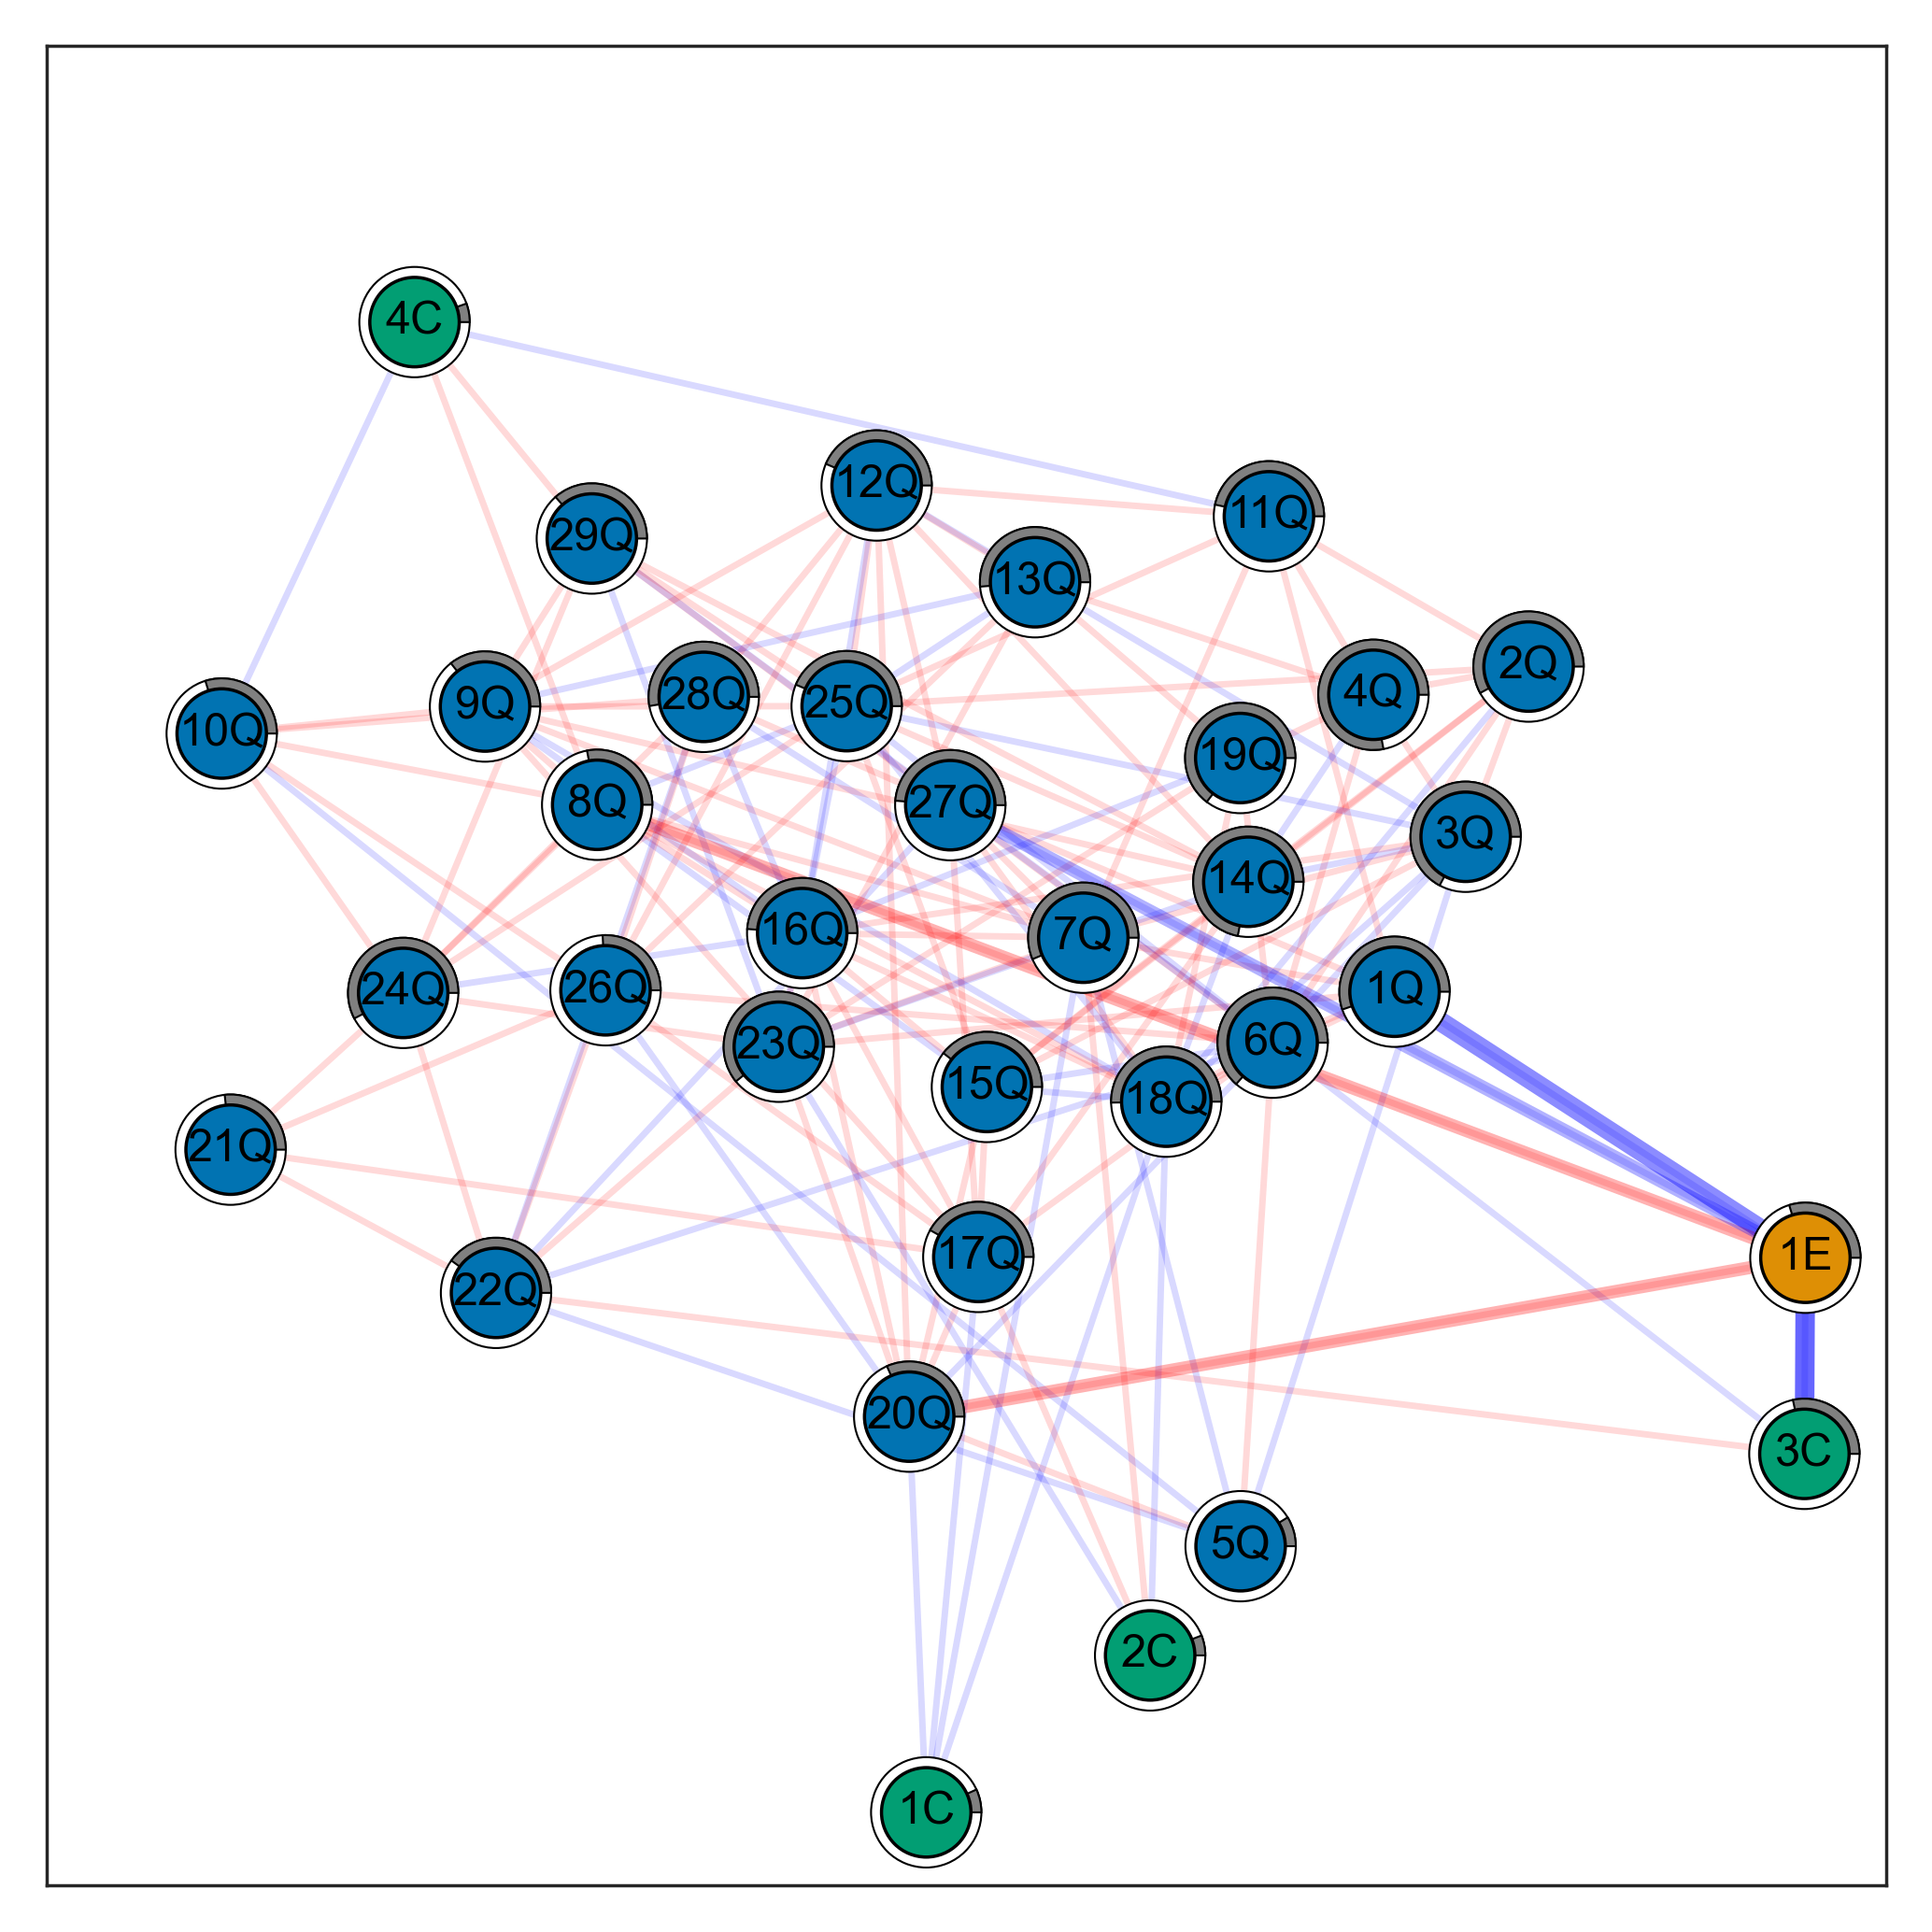

In [21]:
draw_graph(
    links[1], 
    seed=13, 
    basic_links=leave_n_edges_from_eeg(links[1], N=0),
    basic='first', 
    nodes_predictabilities = ern_cov_predictability, 
    specific_positions=positions
) 

#1E,1Q,0.194 - rum
# 1E,8Q,-0.03 - hoard
# 1E,12Q,-0.023 - - WBSI - znika
# 1E,22Q,-0.034 - reward
# 1E,29Q,-0.027 - guilt - znika
# 1E,30Q,0.023 - AMB
# 1E,32Q,0.025 - high stand znika

In [22]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None):
    display(links[1].sort_values('weight'))

var1         var2  weight
230          STAI-T          PUN  -1.039
161  DASS-21 Stress  DASS-21 Dep  -0.947
568             AMB         PRED  -0.832
450              OT      OB_PERF  -0.794
190     DASS-21 Dep       STAI-T  -0.634
139             RRQ       OBSESS  -0.634
281             BIS          PUN  -0.614
562              PS        STAND  -0.596
449              OT        T-CTR  -0.552
241          STAI-T        IUS-I  -0.528
219          STAI-T          BIS  -0.524
476         INDEC_F          PUN  -0.490
520            HARM      OB_PERF  -0.489
586           IUS-P        IUS-I  -0.487
362         BAS_NAG          SES  -0.481
368          OBSESS           OT  -0.451
288             BIS          AMB  -0.440
311           BAS_D           PS  -0.425
406             ORD        CHECK  -0.415
162  DASS-21 Stress       STAI-T  -0.402
196     DASS-21 Dep       OBSESS  -0.401
145             RRQ      INDEC_F  -0.401
144             RRQ         WBSI  -0.399
369          OBSESS         WBSI  -0.391
296           BAS_D     BAS_PRZY  -0.377
501             PUN        IUS-I  -0.376
351         BAS_NAG          REW  -0.374
456              OT        IUS-I  -0.369
135             RRQ          BIS  -0.368
576            PRED        IUS-P  -0.362
297           BAS_D      BAS_NAG  -0.352
551         OB_PERF           PS  -0.343
329        BAS_PRZY          REW  -0.341
164  DASS-21 Stress          BIS  -0.329
541           T-CTR      OB_PERF  -0.325
228          STAI-T         WBSI  -0.304
280             BIS      INDEC_F  -0.300
554         OB_PERF        STAND  -0.292
143             RRQ           OT  -0.279
173  DASS-21 Stress         WBSI  -0.279
273             BIS      BAS_NAG  -0.273
387           HOARD        CHECK  -0.273
519            HARM        T-CTR  -0.265
322        BAS_PRZY        HOARD  -0.263
245     STAI-S Diff          BIS  -0.261
569             AMB        STAND  -0.256
563              PS        IUS-P  -0.251
390           HOARD      INDEC_F  -0.249
416             ORD           PS  -0.235
471            WBSI        IUS-P  -0.226
365          OBSESS        HOARD  -0.222
433           CHECK      OB_PERF  -0.214
320        BAS_PRZY      BAS_NAG  -0.209
570             AMB        IUS-P  -0.205
317           BAS_D          SES  -0.200
419             ORD        STAND  -0.191
396           HOARD      OB_PERF  -0.188
357         BAS_NAG          AMB  -0.186
467            WBSI           PS  -0.180
534            G_SE         PRED  -0.178
181  DASS-21 Stress           PS  -0.178
436           CHECK         PRED  -0.176
386           HOARD          ORD  -0.173
530            G_SE        T-CTR  -0.172
306           BAS_D          REW  -0.172
537            G_SE        IUS-I  -0.161
284             BIS         G_SE  -0.158
536            G_SE        IUS-P  -0.156
431           CHECK         G_SE  -0.156
353         BAS_NAG         G_SE  -0.147
584           STAND  performance  -0.146
257     STAI-S Diff          REW  -0.145
404           HOARD  performance  -0.116
187  DASS-21 Stress          SES  -0.091
345         BAS_NAG          ORD  -0.079
193     DASS-21 Dep        BAS_D  -0.077
366          OBSESS          ORD  -0.075
153             RRQ          AMB  -0.074
422             ORD          SES  -0.073
108        Handness      BAS_NAG  -0.070
378          OBSESS          AMB  -0.059
513             REW        IUS-P  -0.054
587           IUS-P          SES  -0.050
553         OB_PERF         PRED  -0.049
327        BAS_PRZY      INDEC_F  -0.047
109        Handness       OBSESS  -0.046
445              OT          PUN  -0.045
325        BAS_PRZY           OT  -0.045
583           STAND          SES  -0.044
165  DASS-21 Stress        BAS_D  -0.044
321        BAS_PRZY       OBSESS  -0.033
194     DASS-21 Dep     BAS_PRZY  -0.032
446              OT          REW  -0.030
21            e_ERN          REW  -0.030
352         BAS_NAG         HARM  -0.027
57           e_LT_F        T-CTR  -0.026
565              PS          SES  -0.0

Display predictability of nodes

In [24]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_cov_predictability)

e_ERN    e_LT_F       Age  Handness       RRQ  DASS-21 Stress  \
0  0.297613  0.283414  0.067939  0.058827  0.552296        0.579643   

   DASS-21 Dep    STAI-T  STAI-S Diff       BIS    BAS_D  BAS_PRZY   BAS_NAG  \
0     0.671764  0.779158      0.08745  0.635197  0.39476  0.488097  0.419247   

     OBSESS     HOARD       ORD    CHECK       OT      WBSI   INDEC_F  \
0  0.563633  0.279581  0.356297  0.29796  0.60826  0.465944  0.502746   

        PUN       REW      HARM      G_SE     T-CTR   OB_PERF        PS  \
0  0.646206  0.316156  0.267168  0.258326  0.400396  0.576716  0.436356   

        AMB      PRED     STAND     IUS-P     IUS-I      SES  performance  
0  0.487045  0.526643  0.364248  0.435896  0.512764  0.71932     0.054696

Save graph

In [83]:
G_ = nx.from_pandas_edgelist(links[1],'var1','var2', edge_attr='weight', create_using=nx.Graph())
nx.write_gml(G_, '../data/graphs/ern_cov_graph.gml')

- CRN graph

Draw graph

In [25]:
positions = [
    # ('2E', [0.1, 0.8]),
    ('21Q', [-0.8, 0.1])
]

2E,15Q,0.153
2E,16Q,-0.148
2E,8Q,-0.051
2E,24Q,0.163
2E,12Q,-0.021


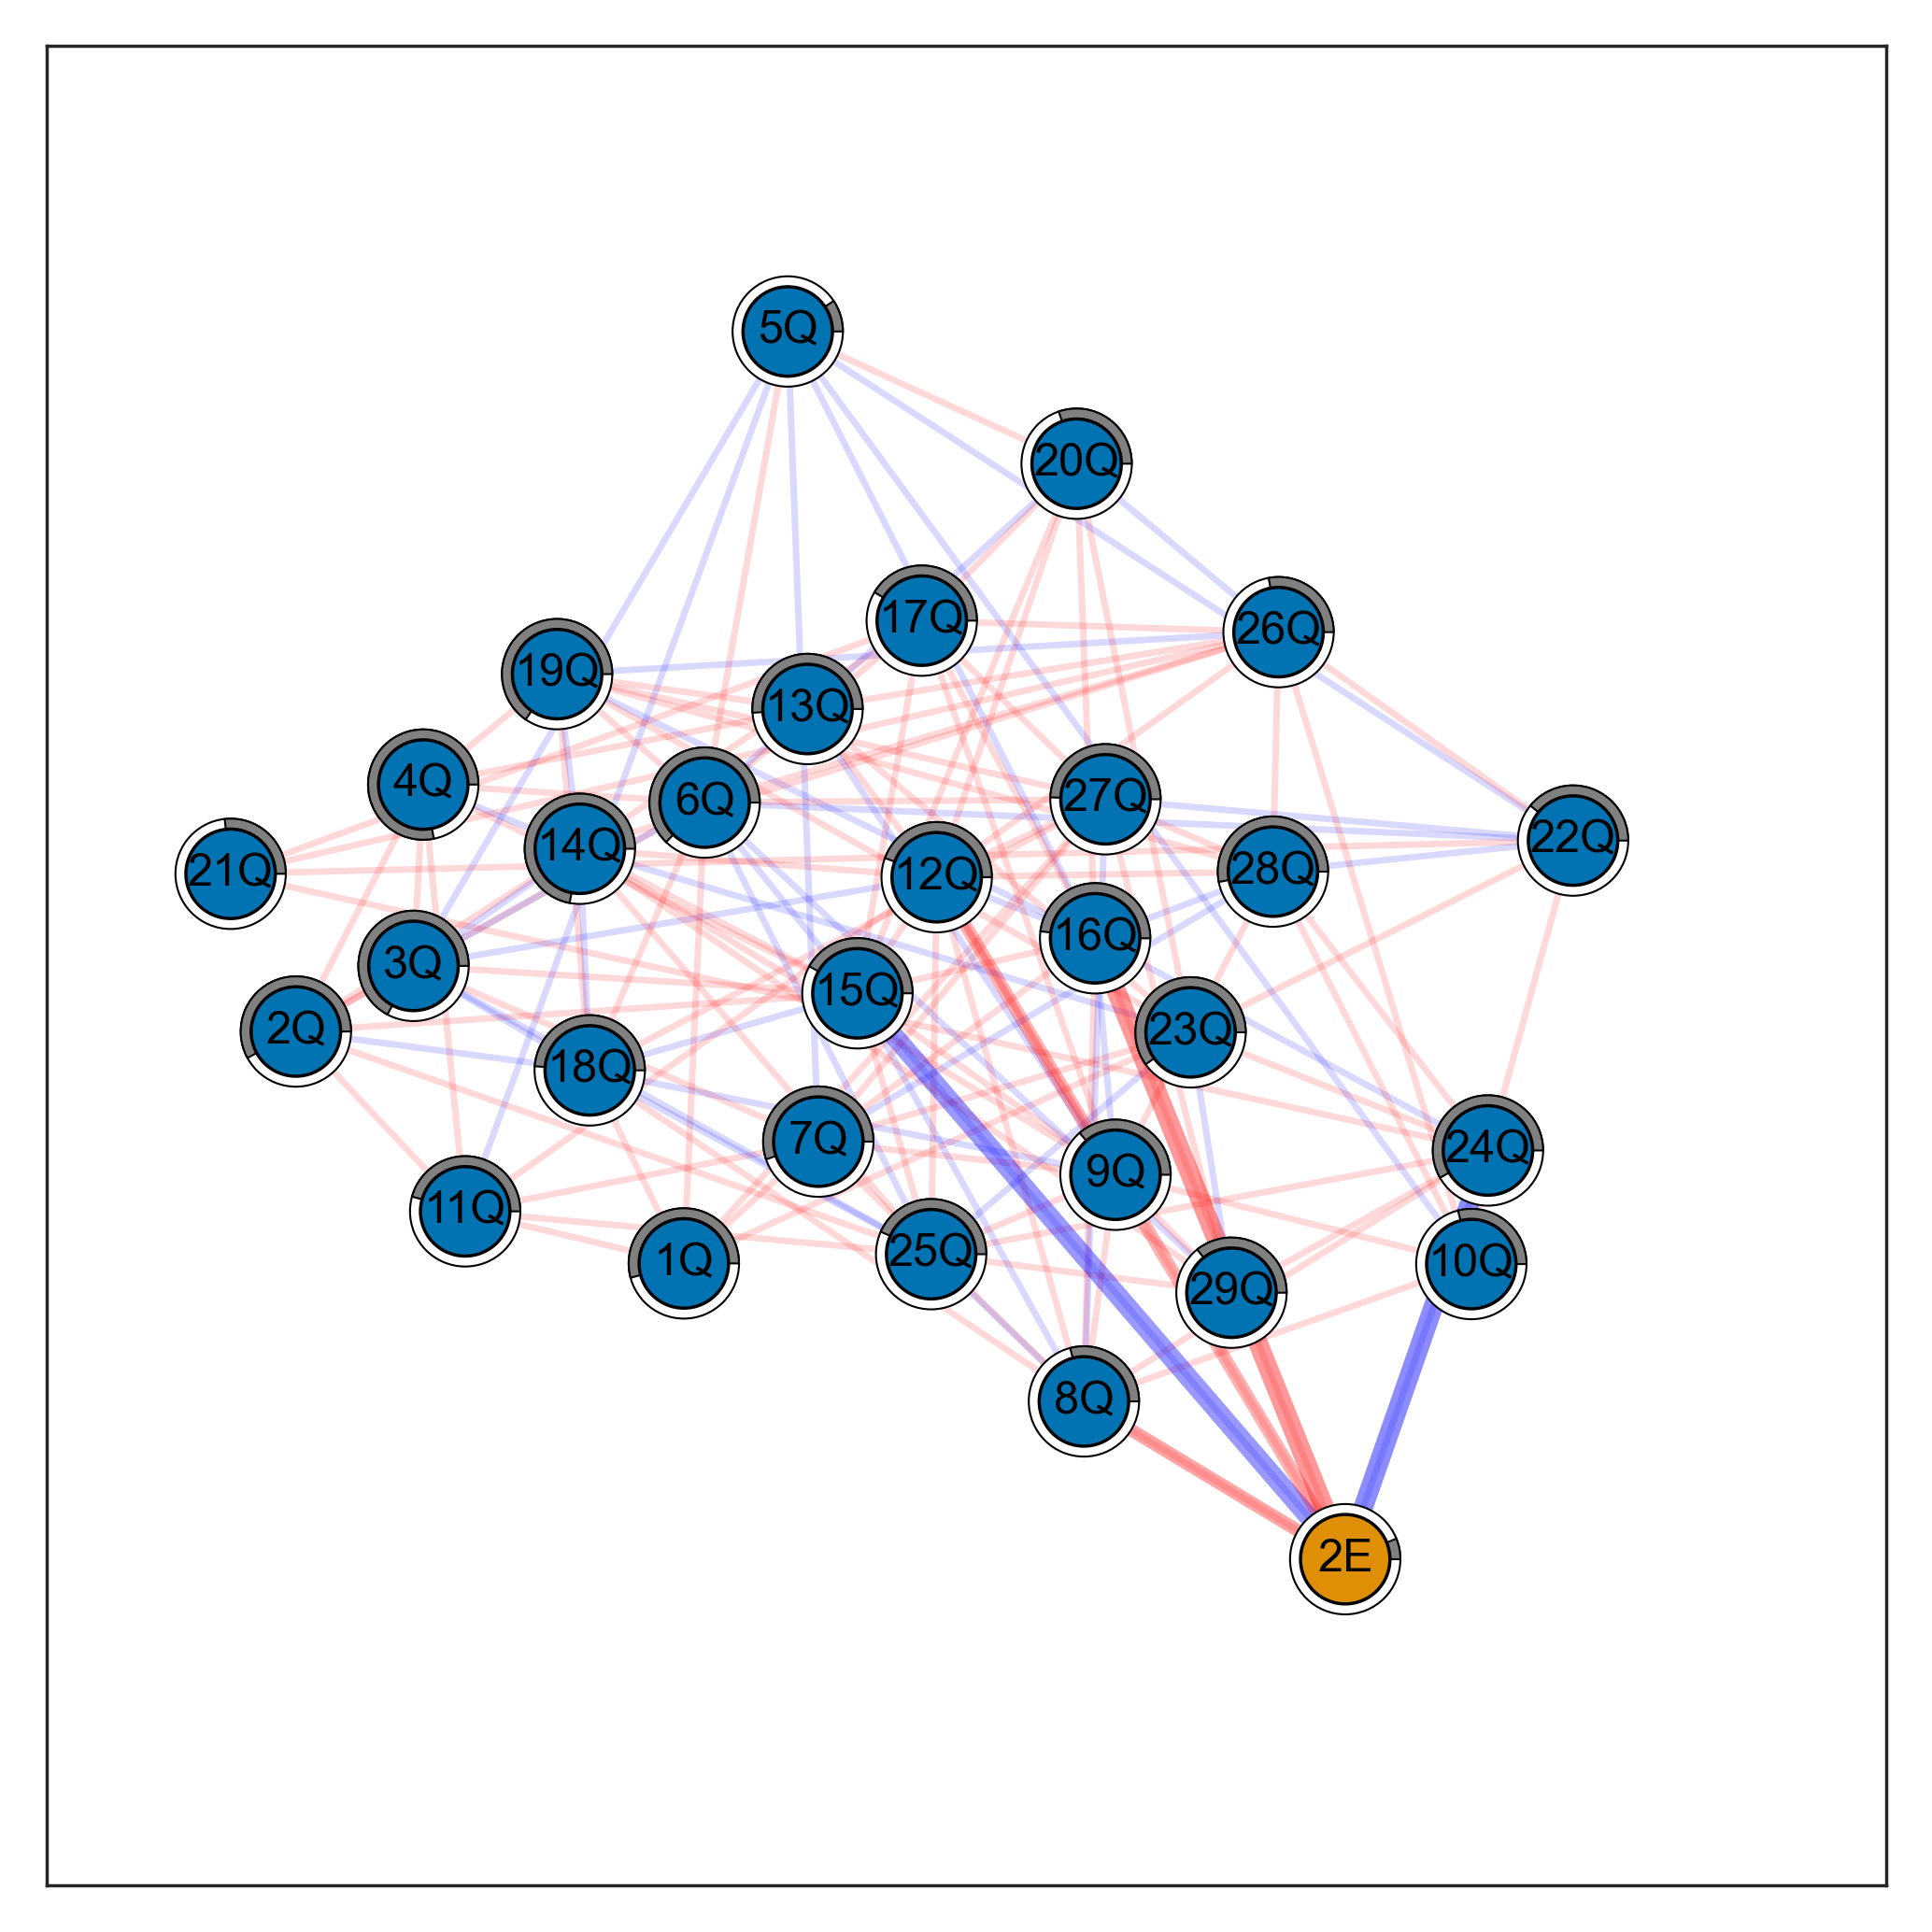

In [26]:
draw_graph(
    links[2], 
    seed=16, 
    basic_links=leave_n_edges_from_eeg(links[2], N=0), 
    basic='first', 
    mapping=mapping_crn, 
    nodes_predictabilities = crn_predictability,
    specific_positions=positions
) 

Display predictability

In [27]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(crn_predictability)

e_CRN       RRQ  DASS-21 Stress  DASS-21 Dep   STAI-T  STAI-S Diff  \
0  0.0609  0.541908        0.579643     0.671727  0.78109     0.093599   

        BIS     BAS_D  BAS_PRZY   BAS_NAG   OBSESS     HOARD     ORD  \
0  0.627077  0.418601  0.479535  0.413931  0.55208  0.290157  0.3629   

      CHECK        OT      WBSI  INDEC_F       PUN     REW      HARM  \
0  0.288755  0.598628  0.456921  0.48813  0.653581  0.3028  0.267168   

       G_SE     T-CTR   OB_PERF        PS       AMB      PRED     STAND  \
0  0.278857  0.390865  0.582525  0.433208  0.494506  0.530123  0.356786   

      IUS-P     IUS-I       SES  
0  0.443591  0.511032  0.720408

In [28]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None):
    display(links[2].sort_values('weight'))

var1         var2  weight
60   DASS-21 Stress  DASS-21 Dep  -0.966
127          STAI-T          PUN  -0.934
445             AMB         PRED  -0.827
337              OT      OB_PERF  -0.800
39              RRQ       OBSESS  -0.646
88      DASS-21 Dep       STAI-T  -0.633
176             BIS          PUN  -0.603
440              PS        STAND  -0.593
336              OT        T-CTR  -0.554
116          STAI-T          BIS  -0.547
138          STAI-T        IUS-I  -0.534
460           IUS-P        IUS-I  -0.511
254         BAS_NAG          SES  -0.505
402            HARM      OB_PERF  -0.485
361         INDEC_F          PUN  -0.470
259          OBSESS           OT  -0.458
94      DASS-21 Dep       OBSESS  -0.420
183             BIS          AMB  -0.414
45              RRQ      INDEC_F  -0.413
61   DASS-21 Stress       STAI-T  -0.411
205           BAS_D           PS  -0.410
190           BAS_D     BAS_PRZY  -0.408
295             ORD        CHECK  -0.404
44              RRQ         WBSI  -0.397
243         BAS_NAG          REW  -0.394
260          OBSESS         WBSI  -0.389
191           BAS_D      BAS_NAG  -0.386
385             PUN        IUS-I  -0.383
343              OT        IUS-I  -0.377
63   DASS-21 Stress          BIS  -0.356
452            PRED        IUS-P  -0.350
35              RRQ          BIS  -0.347
222        BAS_PRZY          REW  -0.346
168             BIS      BAS_NAG  -0.343
430         OB_PERF           PS  -0.340
421           T-CTR      OB_PERF  -0.330
125          STAI-T         WBSI  -0.311
433         OB_PERF        STAND  -0.299
175             BIS      INDEC_F  -0.288
72   DASS-21 Stress         WBSI  -0.276
43              RRQ           OT  -0.274
277           HOARD        CHECK  -0.269
401            HARM        T-CTR  -0.264
141     STAI-S Diff          BIS  -0.264
280           HOARD      INDEC_F  -0.255
446             AMB        STAND  -0.248
215        BAS_PRZY        HOARD  -0.237
441              PS        IUS-P  -0.237
257          OBSESS          ORD  -0.234
357            WBSI        IUS-P  -0.230
305             ORD           PS  -0.224
321           CHECK      OB_PERF  -0.211
213        BAS_PRZY      BAS_NAG  -0.209
286           HOARD      OB_PERF  -0.209
447             AMB        IUS-P  -0.204
211           BAS_D          SES  -0.191
249         BAS_NAG          AMB  -0.187
308             ORD        STAND  -0.184
256          OBSESS        HOARD  -0.182
214        BAS_PRZY       OBSESS  -0.180
418            G_SE        IUS-I  -0.180
179             BIS         G_SE  -0.180
411            G_SE        T-CTR  -0.175
80   DASS-21 Stress           PS  -0.175
353            WBSI           PS  -0.170
319           CHECK         G_SE  -0.166
415            G_SE         PRED  -0.165
200           BAS_D          REW  -0.163
276           HOARD          ORD  -0.163
417            G_SE        IUS-P  -0.159
153     STAI-S Diff          REW  -0.150
307             ORD         PRED  -0.150
8             e_CRN     BAS_PRZY  -0.148
324           CHECK         PRED  -0.144
86   DASS-21 Stress          SES  -0.123
53              RRQ          AMB  -0.086
91      DASS-21 Dep        BAS_D  -0.086
245         BAS_NAG         G_SE  -0.083
311             ORD          SES  -0.078
237         BAS_NAG          ORD  -0.077
396             REW        IUS-P  -0.076
64   DASS-21 Stress        BAS_D  -0.073
269          OBSESS          AMB  -0.069
461           IUS-P          SES  -0.060
11            e_CRN        HOARD  -0.051
419            G_SE          SES  -0.050
458           STAND          SES  -0.049
333              OT          REW  -0.048
382             PUN         PRED  -0.043
332              OT          PUN  -0.042
209           BAS_D        IUS-P  -0.038
244         BAS_NAG         HARM  -0.034
117          STAI-T        BAS_D  -0.033
400            HARM         G_SE  -0.032
368         INDEC_F          AMB  -0.031
194           BAS_D          ORD  -0.031
432         OB_PERF         PRED  -0.0

Save graph

In [88]:
G_ = nx.from_pandas_edgelist(links[2],'var1','var2', edge_attr='weight', create_using=nx.Graph())
nx.write_gml(G_, '../data/graphs/crn_graph.gml')

- CRN cov graph

Draw graph

In [29]:
positions = [
    ('2C', [-0.05, 0.9]),
    # ('2C', [0.2, 0.1])
]

2E,3C,0.436
2E,15Q,0.039
2E,16Q,-0.053
2E,8Q,-0.026
2E,24Q,0.066
2E,25Q,0.02


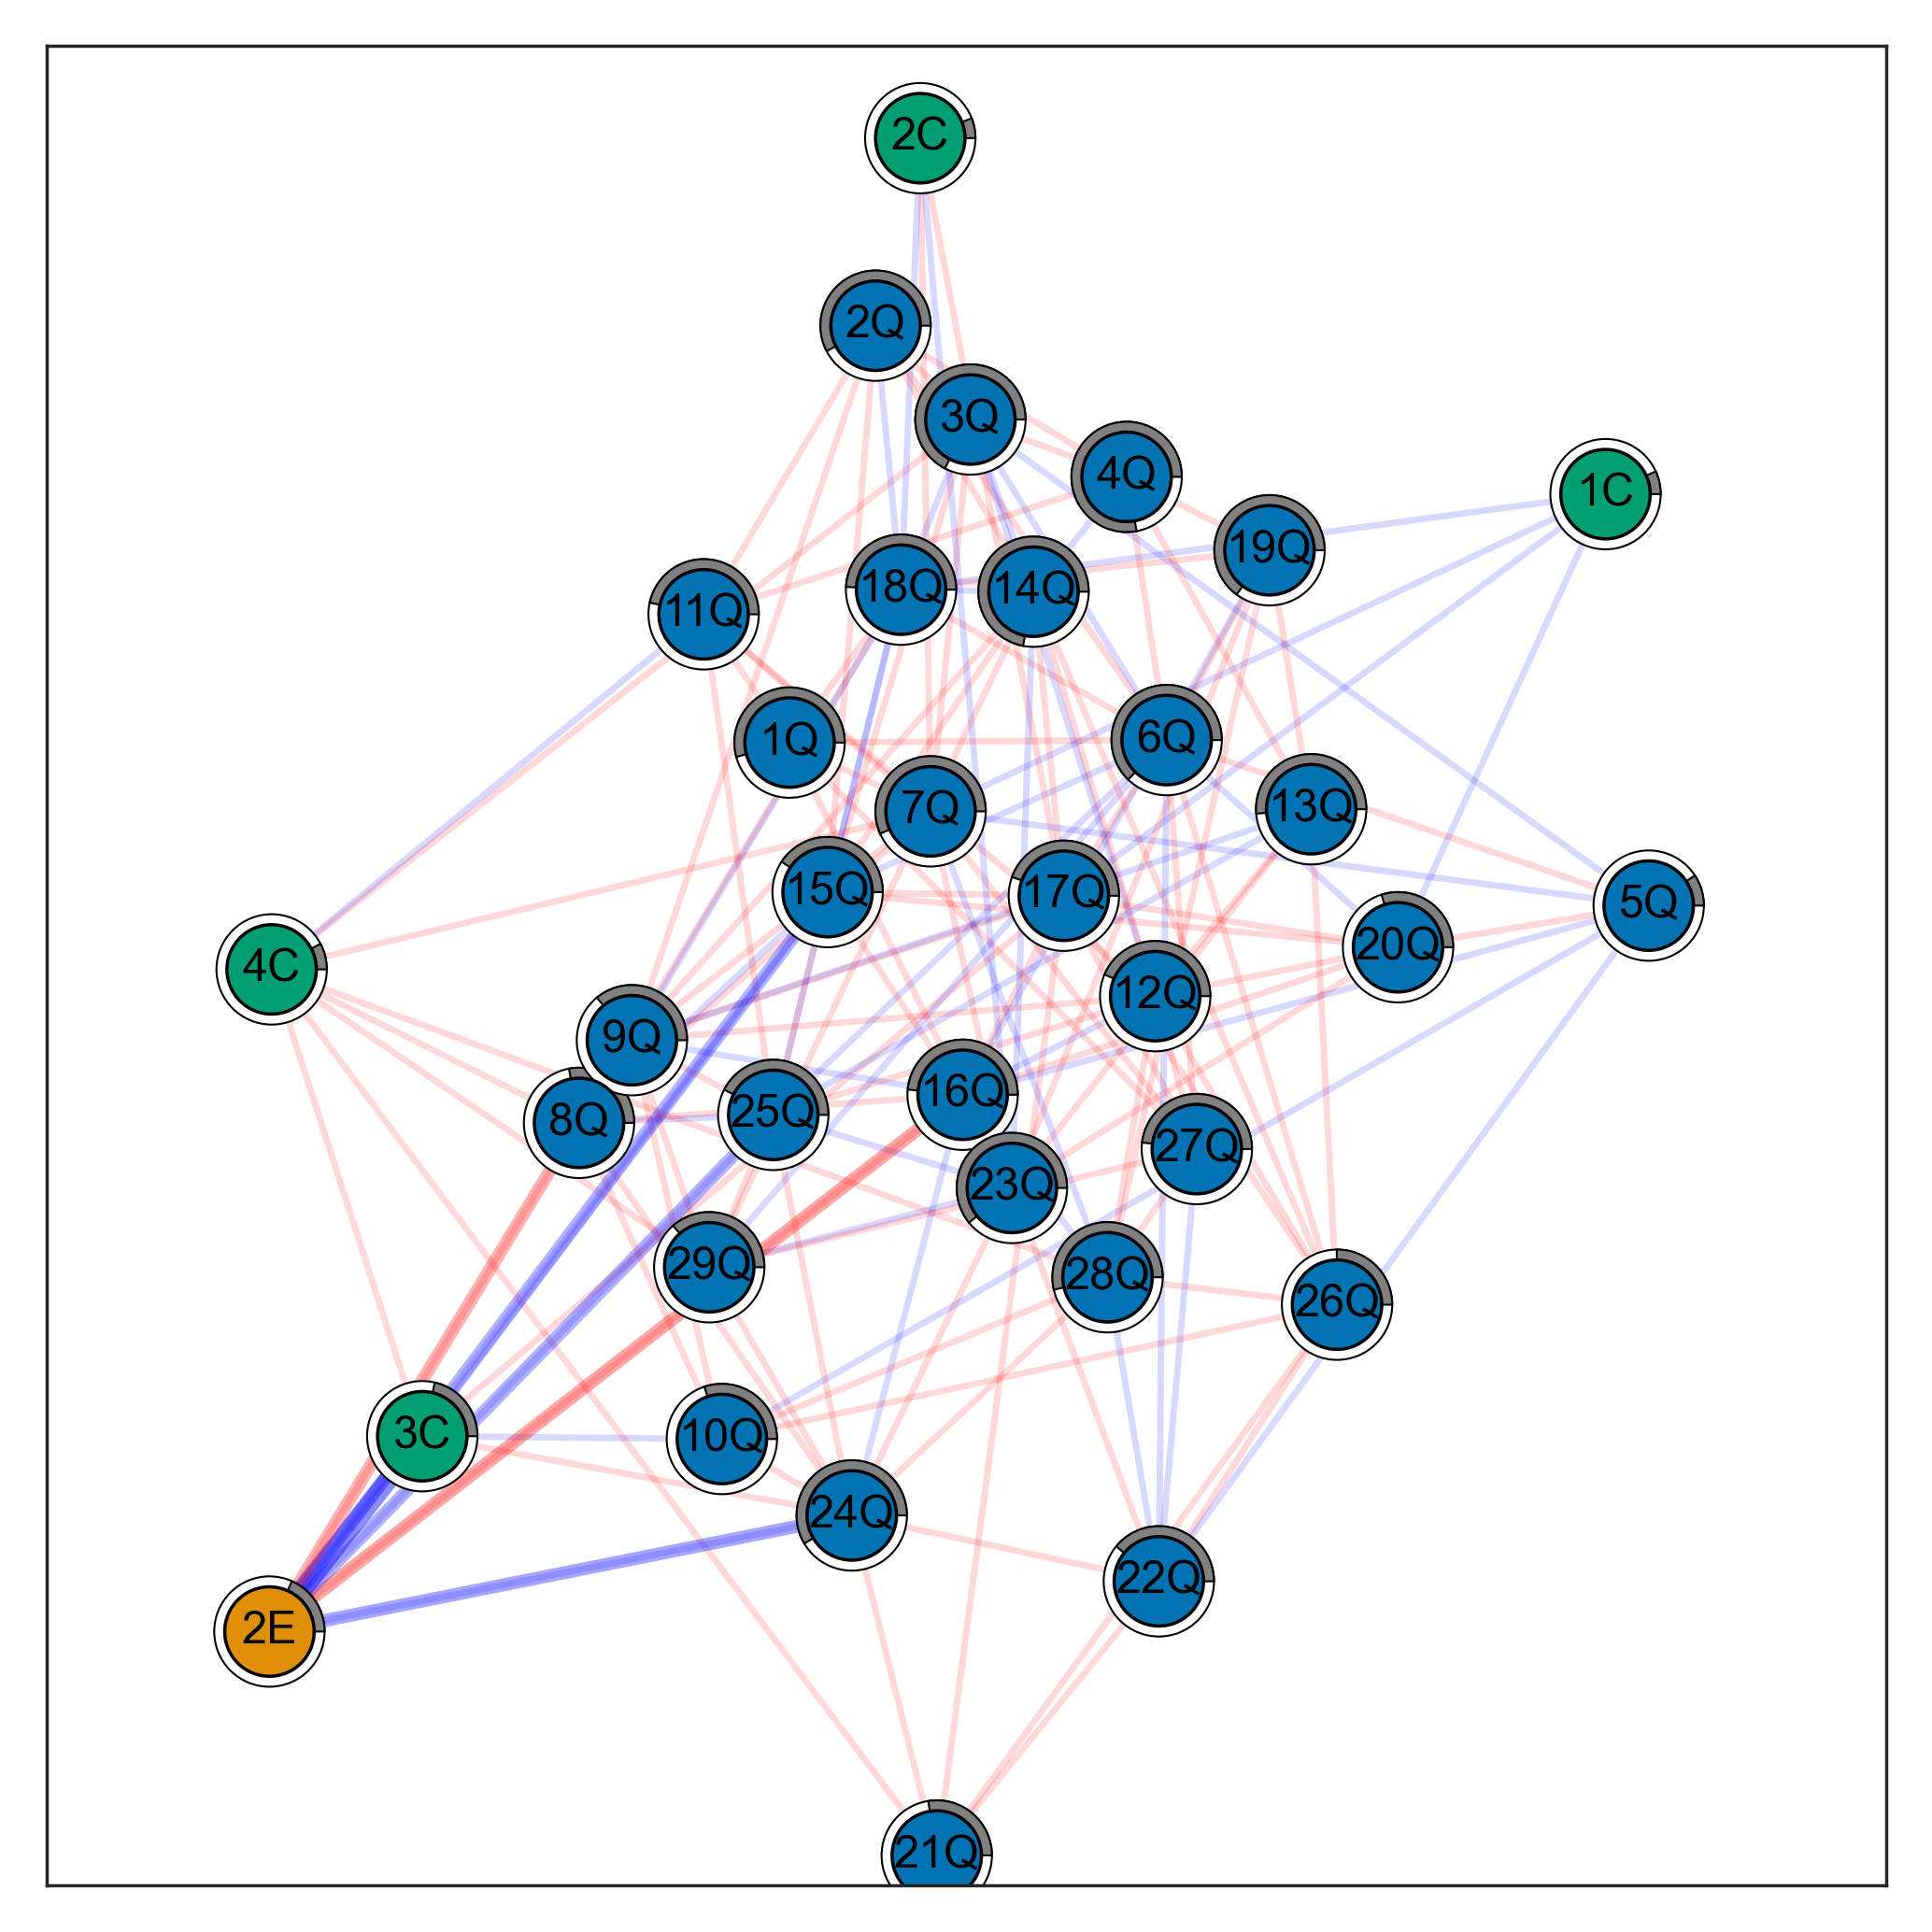

In [30]:
draw_graph(
    links[3], 
    seed=13, 
    basic_links=leave_n_edges_from_eeg(links[3], N=0), 
    basic='first', 
    mapping=mapping_crn,
    nodes_predictabilities = crn_cov_predictability,
    specific_positions = positions
) 

Display predictability of nodes

In [31]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(crn_cov_predictability)

e_CRN  e_LT_F2_C       Age  Handness       RRQ  DASS-21 Stress  \
0  0.183273   0.213325  0.067939  0.058827  0.541908        0.576316   

   DASS-21 Dep    STAI-T  STAI-S Diff       BIS     BAS_D  BAS_PRZY   BAS_NAG  \
0     0.673284  0.779158     0.091887  0.627077  0.407234  0.484897  0.444706   

     OBSESS     HOARD       ORD     CHECK       OT      WBSI   INDEC_F  \
0  0.566578  0.279413  0.359532  0.301502  0.60826  0.465944  0.492019   

        PUN       REW     HARM      G_SE     T-CTR   OB_PERF       PS  \
0  0.648324  0.298648  0.27473  0.250893  0.390865  0.585095  0.42457   

        AMB      PRED     STAND     IUS-P     IUS-I       SES  performance  
0  0.481019  0.536242  0.364248  0.435896  0.512764  0.719585     0.076855

In [32]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None):
    display(links[3].sort_values('var1'))

var1         var2  weight
570             AMB        IUS-P  -0.203
569             AMB        STAND  -0.257
568             AMB         PRED  -0.836
84              Age      INDEC_F   0.070
77              Age      BAS_NAG   0.121
78              Age       OBSESS   0.070
86              Age          REW   0.128
296           BAS_D     BAS_PRZY  -0.384
297           BAS_D      BAS_NAG  -0.355
299           BAS_D        HOARD   0.042
304           BAS_D      INDEC_F   0.164
306           BAS_D          REW  -0.169
311           BAS_D           PS  -0.426
317           BAS_D          SES  -0.216
357         BAS_NAG          AMB  -0.194
353         BAS_NAG         G_SE  -0.043
351         BAS_NAG          REW  -0.372
362         BAS_NAG          SES  -0.477
352         BAS_NAG         HARM  -0.030
345         BAS_NAG          ORD  -0.091
322        BAS_PRZY        HOARD  -0.260
323        BAS_PRZY          ORD   0.268
325        BAS_PRZY           OT  -0.031
328        BAS_PRZY          PUN   0.095
333        BAS_PRZY      OB_PERF   0.030
336        BAS_PRZY         PRED   0.630
338        BAS_PRZY        IUS-P   0.139
320        BAS_PRZY      BAS_NAG  -0.205
329        BAS_PRZY          REW  -0.346
273             BIS      BAS_NAG  -0.284
290             BIS        STAND   0.056
288             BIS          AMB  -0.430
287             BIS           PS   0.071
285             BIS        T-CTR   0.030
284             BIS         G_SE  -0.177
282             BIS          REW   0.110
281             BIS          PUN  -0.608
280             BIS      INDEC_F  -0.301
271             BIS        BAS_D   0.103
436           CHECK         PRED  -0.176
431           CHECK         G_SE  -0.160
433           CHECK      OB_PERF  -0.230
215     DASS-21 Dep          SES   0.862
216     DASS-21 Dep  performance  -0.031
190     DASS-21 Dep       STAI-T  -0.624
191     DASS-21 Dep  STAI-S Diff   0.025
192     DASS-21 Dep          BIS   0.147
193     DASS-21 Dep        BAS_D  -0.065
196     DASS-21 Dep       OBSESS  -0.399
213     DASS-21 Dep        IUS-P   0.027
202     DASS-21 Dep      INDEC_F   0.178
164  DASS-21 Stress          BIS  -0.325
173  DASS-21 Stress         WBSI  -0.304
187  DASS-21 Stress          SES  -0.100
174  DASS-21 Stress      INDEC_F   0.063
161  DASS-21 Stress  DASS-21 Dep  -0.936
165  DASS-21 Stress        BAS_D  -0.090
170  DASS-21 Stress          ORD  -0.022
162  DASS-21 Stress       STAI-T  -0.407
538            G_SE          SES  -0.038
537            G_SE        IUS-I  -0.160
536            G_SE        IUS-P  -0.158
534            G_SE         PRED  -0.176
530            G_SE        T-CTR  -0.173
519            HARM        T-CTR  -0.265
528            HARM  performance  -0.024
520            HARM      OB_PERF  -0.488
518            HARM         G_SE  -0.024
386           HOARD          ORD  -0.173
387           HOARD        CHECK  -0.269
404           HOARD  performance  -0.040
397           HOARD           PS   0.059
396           HOARD      OB_PERF  -0.191
390           HOARD      INDEC_F  -0.248
109        Handness       OBSESS  -0.046
108        Handness      BAS_NAG  -0.070
115        Handness      INDEC_F   0.055
113        Handness           OT   0.036
488         INDEC_F          SES   0.471
482         INDEC_F           PS   0.059
476         INDEC_F          PUN  -0.483
587           IUS-P          SES  -0.046
586           IUS-P        IUS-I  -0.489
379          OBSESS         PRED   0.272
384          OBSESS  performance  -0.038
365          OBSESS        HOARD  -0.219
366          OBSESS          ORD  -0.069
368          OBSESS           OT  -0.452
369          OBSESS         WBSI  -0.393
378          OBSESS          AMB  -0.060
551         OB_PERF           PS  -0.340
554         OB_PERF        STAND  -0.291
553         OB_PERF         PRED  -0.048
422             ORD          SES  -0.077
421             ORD        IUS-I   0.036
420             ORD        IUS-P  -0.020
419             ORD        STAND  -0.1

Save graph

In [93]:
G_ = nx.from_pandas_edgelist(links[3],'var1','var2', edge_attr='weight', create_using=nx.Graph())
nx.write_gml(G_, '../data/graphs/crn_cov_graph.gml')

##### Test links

In [94]:
sns.set(rc={'figure.figsize':(30 , 30)})

if test:   
    for i, this_links in enumerate(links_test):
        plt.figure(i)
        draw_graph(leave_n_edges_from_eeg(this_links, N=0))

## Visualize ERN and CRN graphs difference

### 1. Continuous difference: based on precision matrixes

Define precision matrices

In [95]:
ern_precision = precision_matrixes[0]
ern_cov_precision = precision_matrixes[1]
crn_precision = precision_matrixes[2]
crn_cov_precision = precision_matrixes[3]

precision_matrices = [ern_precision, ern_cov_precision, crn_precision, crn_cov_precision]

Define node labels mappers

In [96]:
mapping_ern = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    # "OCI-R": "11Q",
    "WBSI": "11Q",
    "IUS-P": "12Q",
    "IUS-I": "13Q",
    "SES": "14Q",
    'BAS_D': "15Q",
    'BAS_PRZY': "16Q",
    'BAS_NAG': "17Q",
    'INDEC_F': "18Q",
    'PUN': "19Q",
    'REW': "20Q",
    'HARM': "21Q",
    'T-CTR': "22Q",
    "OT": "23Q",
    'OB_PERF': "24Q",
    # 'CMDA': "25Q",
    'PS': "25Q",
    'G_SE': "26Q",
    'AMB': "27Q",
    'PRED': "28Q",
    'STAND': "29Q",   
    "Age": "1C",
    # "Sex": "2C",
    "Handness": "2C",
    'e_ERN': "1E",
    'e_LT_F': "3C",
    'performance': "4C",
}

mapping_crn = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    # "OCI-R": "11Q",
    "WBSI": "11Q",
    "IUS-P": "12Q",
    "IUS-I": "13Q",
    "SES": "14Q",
    'BAS_D': "15Q",
    'BAS_PRZY': "16Q",
    'BAS_NAG': "17Q",
    'INDEC_F': "18Q",
    'PUN': "19Q",
    'REW': "20Q",
    'HARM': "21Q",
    'T-CTR': "22Q",
    "OT": "23Q",
    'OB_PERF': "24Q",
    # 'CMDA': "25Q",
    'PS': "25Q",
    'G_SE': "26Q",
    'AMB': "27Q",
    'PRED': "28Q",
    'STAND': "29Q",   
    "Age": "1C",
    # "Sex": "2C",
    "Handness": "2C",
    'e_CRN': "1E",
    'e_LT_F2_C': "3C",
    'performance': "4C",
}

Create links from precision matrices

- Here, the threshold is set very low so as not to introduce an artificial qualitative difference between ERN and CRN networks when the link is slightly below the threshold in one network (and will be zeroed) and slightly above in the second (and will not be zeroed).

In [97]:
links_for_diffs = []

for matrix_ in precision_matrices: 
    this_link = leave_n_edges_from_eeg(get_links(matrix_, threshold=0.005), N=2)
    # this_link = get_links(matix, threshold=0.005)
    links_for_diffs.append(this_link)

Create graphs from provided links

In [98]:
def create_g(links, mapping):
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    return G

In [99]:
ern_graph = create_g(links_for_diffs[0], mapping_ern)
ern_cov_graph = create_g(links_for_diffs[1], mapping_ern)
crn_graph = create_g(links_for_diffs[2], mapping_crn)
crn_cov_graph = create_g(links_for_diffs[3], mapping_crn)

Return difference between two graphs

- In addition to the graph difference, the coloring and linestyle of the links are also returned, which together inform about the exact difference between the two networks.

- The threshold is set for the maximum difference between the link in two nets, which will be considered as no difference (this indicates no change between nets).

In [100]:
# edges that was exaxtly the same are purple colored
def get_diff_graph(ern_graph, crn_graph, threshold=0.035):
    colors = []
    linestyle = []
    remove = []

    diff_graph = ern_graph.copy()
    ern_edges = ern_graph.edges()


    for u,v in ern_edges:
        # print(f"{u},{v},{ern_graph[u][v]['weight']}")
        if u not in crn_graph.nodes():
            # print(f"Not in CRN graph - node: {u}")
            if abs(ern_graph[u][v]['weight']) <= 0.02: # zero links that does not exceed link threshold 
                print(f"{u},{v},{ern_graph[u][v]['weight']} unique ERN but too low")
                diff_graph.remove_edge(u, v)
            else:
                this_color = 'red' if ern_graph[u][v]['weight'] < 0 else 'blue'
                colors.append(this_color)
                linestyle.append('solid')
        else:
            if (v not in crn_graph[u].keys()): # link did not exist in CRN (so there is no change)
                # colors.append('green')
                # print("no change")
                # print(f"link did not exist in CRN - edge: {u} - {v}")
                if abs(ern_graph[u][v]['weight']) <= 0.02: # zero links that does not exceed link threshold 
                    print(f"{u},{v},{ern_graph[u][v]['weight']} unique ERN but too low")
                    diff_graph.remove_edge(u, v)
                else:
                    this_color = 'red' if ern_graph[u][v]['weight'] < 0 else 'blue'
                    colors.append(this_color)
                    linestyle.append('solid')

            elif (ern_graph[u][v]['weight'] < 0) & (crn_graph[u][v]['weight'] < 0):
                diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']

                if abs(diff) <= threshold:
                    colors.append('purple')
                    linestyle.append('solid')
                    # print("purple")
                else:
                    diff_graph[u][v]['weight'] = diff
                    colors.append('red')
                    this_linestyle = 'dashed' if diff < 0 else ':'
                    linestyle.append(this_linestyle)
                    print(f"{u},{v},{ern_graph[u][v]['weight']} enlarged/dropped red")
                    # print("red")

            elif (ern_graph[u][v]['weight'] > 0) & (crn_graph[u][v]['weight'] > 0):
                diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']

                if abs(diff) <= threshold:
                    colors.append('purple')
                    linestyle.append('solid')
                    # print("purple")

                else:
                    diff_graph[u][v]['weight'] = diff
                    colors.append('blue')
                    this_linestyle = ':' if diff < 0 else 'dashed'
                    linestyle.append(this_linestyle)
                    print(f"{u},{v},{ern_graph[u][v]['weight']} enlarged/dropped blue")
                    # print('blue')

            elif (ern_graph[u][v]['weight'] > 0) & (crn_graph[u][v]['weight'] < 0):
                colors.append('blue')
                diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']
                diff_graph[u][v]['weight'] = diff
                this_linestyle = ':' # link change the sign; the color indicate ERN sign
                linestyle.append(this_linestyle)
                # print("blue change")


            elif (ern_graph[u][v]['weight'] < 0) & (crn_graph[u][v]['weight'] > 0):
                colors.append('red')
                diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']
                diff_graph[u][v]['weight'] = diff
                this_linestyle = ':' # link change the sign; the color indicate ERN sign
                linestyle.append(this_linestyle)
                # print("red change")
            else:
                print("##################### ZLE")
            
        
    return diff_graph, colors, linestyle

In [101]:
def draw_graph_diff_full(G, colors, linestyle='solid', no_purple = False, seed=1, scale=1, k=1):
    
    cm = 1/2.54
    dpi = 500

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    sns.set_style("white")
    palette = sns.color_palette("colorblind")
    
    fig = plt.figure(3, figsize=(10*cm, 10*cm))
    axes = fig.add_axes([0,0,1,1], aspect=1)
    axes.set_xlim([-1,1])
    axes.set_ylim([-1,1])
    
    colors_ = colors
    linestyle_ = linestyle
    
    G_copy = G.copy()
    edges = G_copy.edges()
        
    for u,v in edges:
        G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
    
     # set position
    # pos_i = nx.spring_layout(G_copy, k=k, iterations=1000, scale=scale, seed=seed)
    pos_i = nx.spring_layout(G_copy, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=scale, seed=seed)
    pos=pos_i

    # pos = nx.kamada_kawai_layout(G_copy,  pos = pos_i, scale=scale)
    
    ####################################################################################33
    
    if no_purple:
        edges = G.edges()
        for index, edge in enumerate(edges):
            if colors[index] == 'purple':
                G.remove_edge(edge[0], edge[1])
        G.remove_nodes_from(list(nx.isolates(G)))
        
        purple_indexes = [i for i, e in enumerate(colors) if e == 'purple']
        colors_ = [i for j, i in enumerate(colors) if j not in purple_indexes]
        linestyle_ = [i for j, i in enumerate(linestyle) if j not in purple_indexes]
                
    # G_copy = G.copy()
    # edges = G_copy.edges()
        
#     for u,v in edges:
#         G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
        
#     # set nodes colors
#     node_color=[palette[0] if node.find('Q') != -1 
#                 else palette[1]if node.find('E') != -1 
#                 else palette[2] for node in G_copy.nodes()]
        
    
    # set position
    # pos_i = nx.spring_layout(G_copy, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=1, seed=seed)
    # pos = nx.kamada_kawai_layout(G_copy, pos=pos_i, scale=1)
    
    G_copy = G.copy()
    edges = G_copy.edges()
        
    for u,v in edges:
        G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
    
     # set position
    pos_i = nx.spring_layout(G_copy, k=k, iterations=1000, scale=scale, seed=seed)
    pos=pos_i
    
    # set nodes colors
    node_color=[palette[0] if node.find('Q') != -1 
                else palette[1]if node.find('E') != -1 
                else palette[2] for node in G.nodes()]
            
    edges = G.edges()
    
    
    weights = []
    for u,v in edges:
        weight = G[u][v]['weight']
        # print(f"{u},{v},{weight}")
        # print(f"{u},{v},{weight}")

        weights.append(weight)

    edge_color = colors_

    weights_alphas = []
    weight_bold = []

    for index, edge_weight in enumerate(weights):
        if colors_[index] == 'purple':
            alpha = 0.25
            bold = 1.2
        # elif abs(edge_weight) == 0:
        #     alpha = 0
        #     bold = 0
        elif abs(edge_weight) < 0.05:
            alpha = 0.4 
            bold = 2
        elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.09:
            alpha = 0.45
            bold = 2
        elif abs(edge_weight) >= 0.09 and abs(edge_weight) < 0.16:
            alpha = 0.5
            bold = 3
        elif abs(edge_weight) >= 0.16 and abs(edge_weight) < 0.5:
            alpha = 0.45
            bold = 3
        else:
            alpha = 0.6
            bold = 3
        weights_alphas.append(alpha)
        weight_bold.append(bold)
    
    
    nx.draw_networkx_nodes(
        G, 
        pos=pos,
        linewidths=0.5,
        edgecolors='black',
        node_size = 200,
        node_color=node_color,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=7,
    )
    
    nx.draw_networkx_edges(
        G, 
        pos=pos,
        edgelist = G.edges(),
        edge_color = edge_color,
        style = linestyle_,
        alpha=weights_alphas,
        width = weight_bold,
    )
    
    
    plt.show()   

##### Draw the graphs

crn_graphern_graph- ERN - CRN model

1E,8Q,-0.03 enlarged/dropped red
1E,10Q,-0.02 unique ERN but too low
1E,22Q,0.013 unique ERN but too low
8Q,25Q,0.04 enlarged/dropped blue
20Q,26Q,0.158 enlarged/dropped blue
26Q,17Q,-0.181 enlarged/dropped red
26Q,21Q,-0.113 enlarged/dropped red
26Q,22Q,-0.15 enlarged/dropped red
26Q,14Q,-0.005 enlarged/dropped red
6Q,17Q,-0.32 enlarged/dropped red
6Q,25Q,0.018 enlarged/dropped blue
9Q,14Q,-0.108 enlarged/dropped red
9Q,13Q,0.072 enlarged/dropped blue
9Q,18Q,0.033 enlarged/dropped blue
9Q,4Q,0.009 unique ERN but too low
25Q,18Q,0.209 enlarged/dropped blue
14Q,4Q,1.569 enlarged/dropped blue
14Q,18Q,0.485 enlarged/dropped blue
14Q,21Q,-0.014 unique ERN but too low
18Q,15Q,0.077 enlarged/dropped blue
18Q,19Q,-0.491 enlarged/dropped red
4Q,19Q,-1.047 enlarged/dropped red
17Q,21Q,-0.013 enlarged/dropped red
15Q,16Q,-0.382 enlarged/dropped red


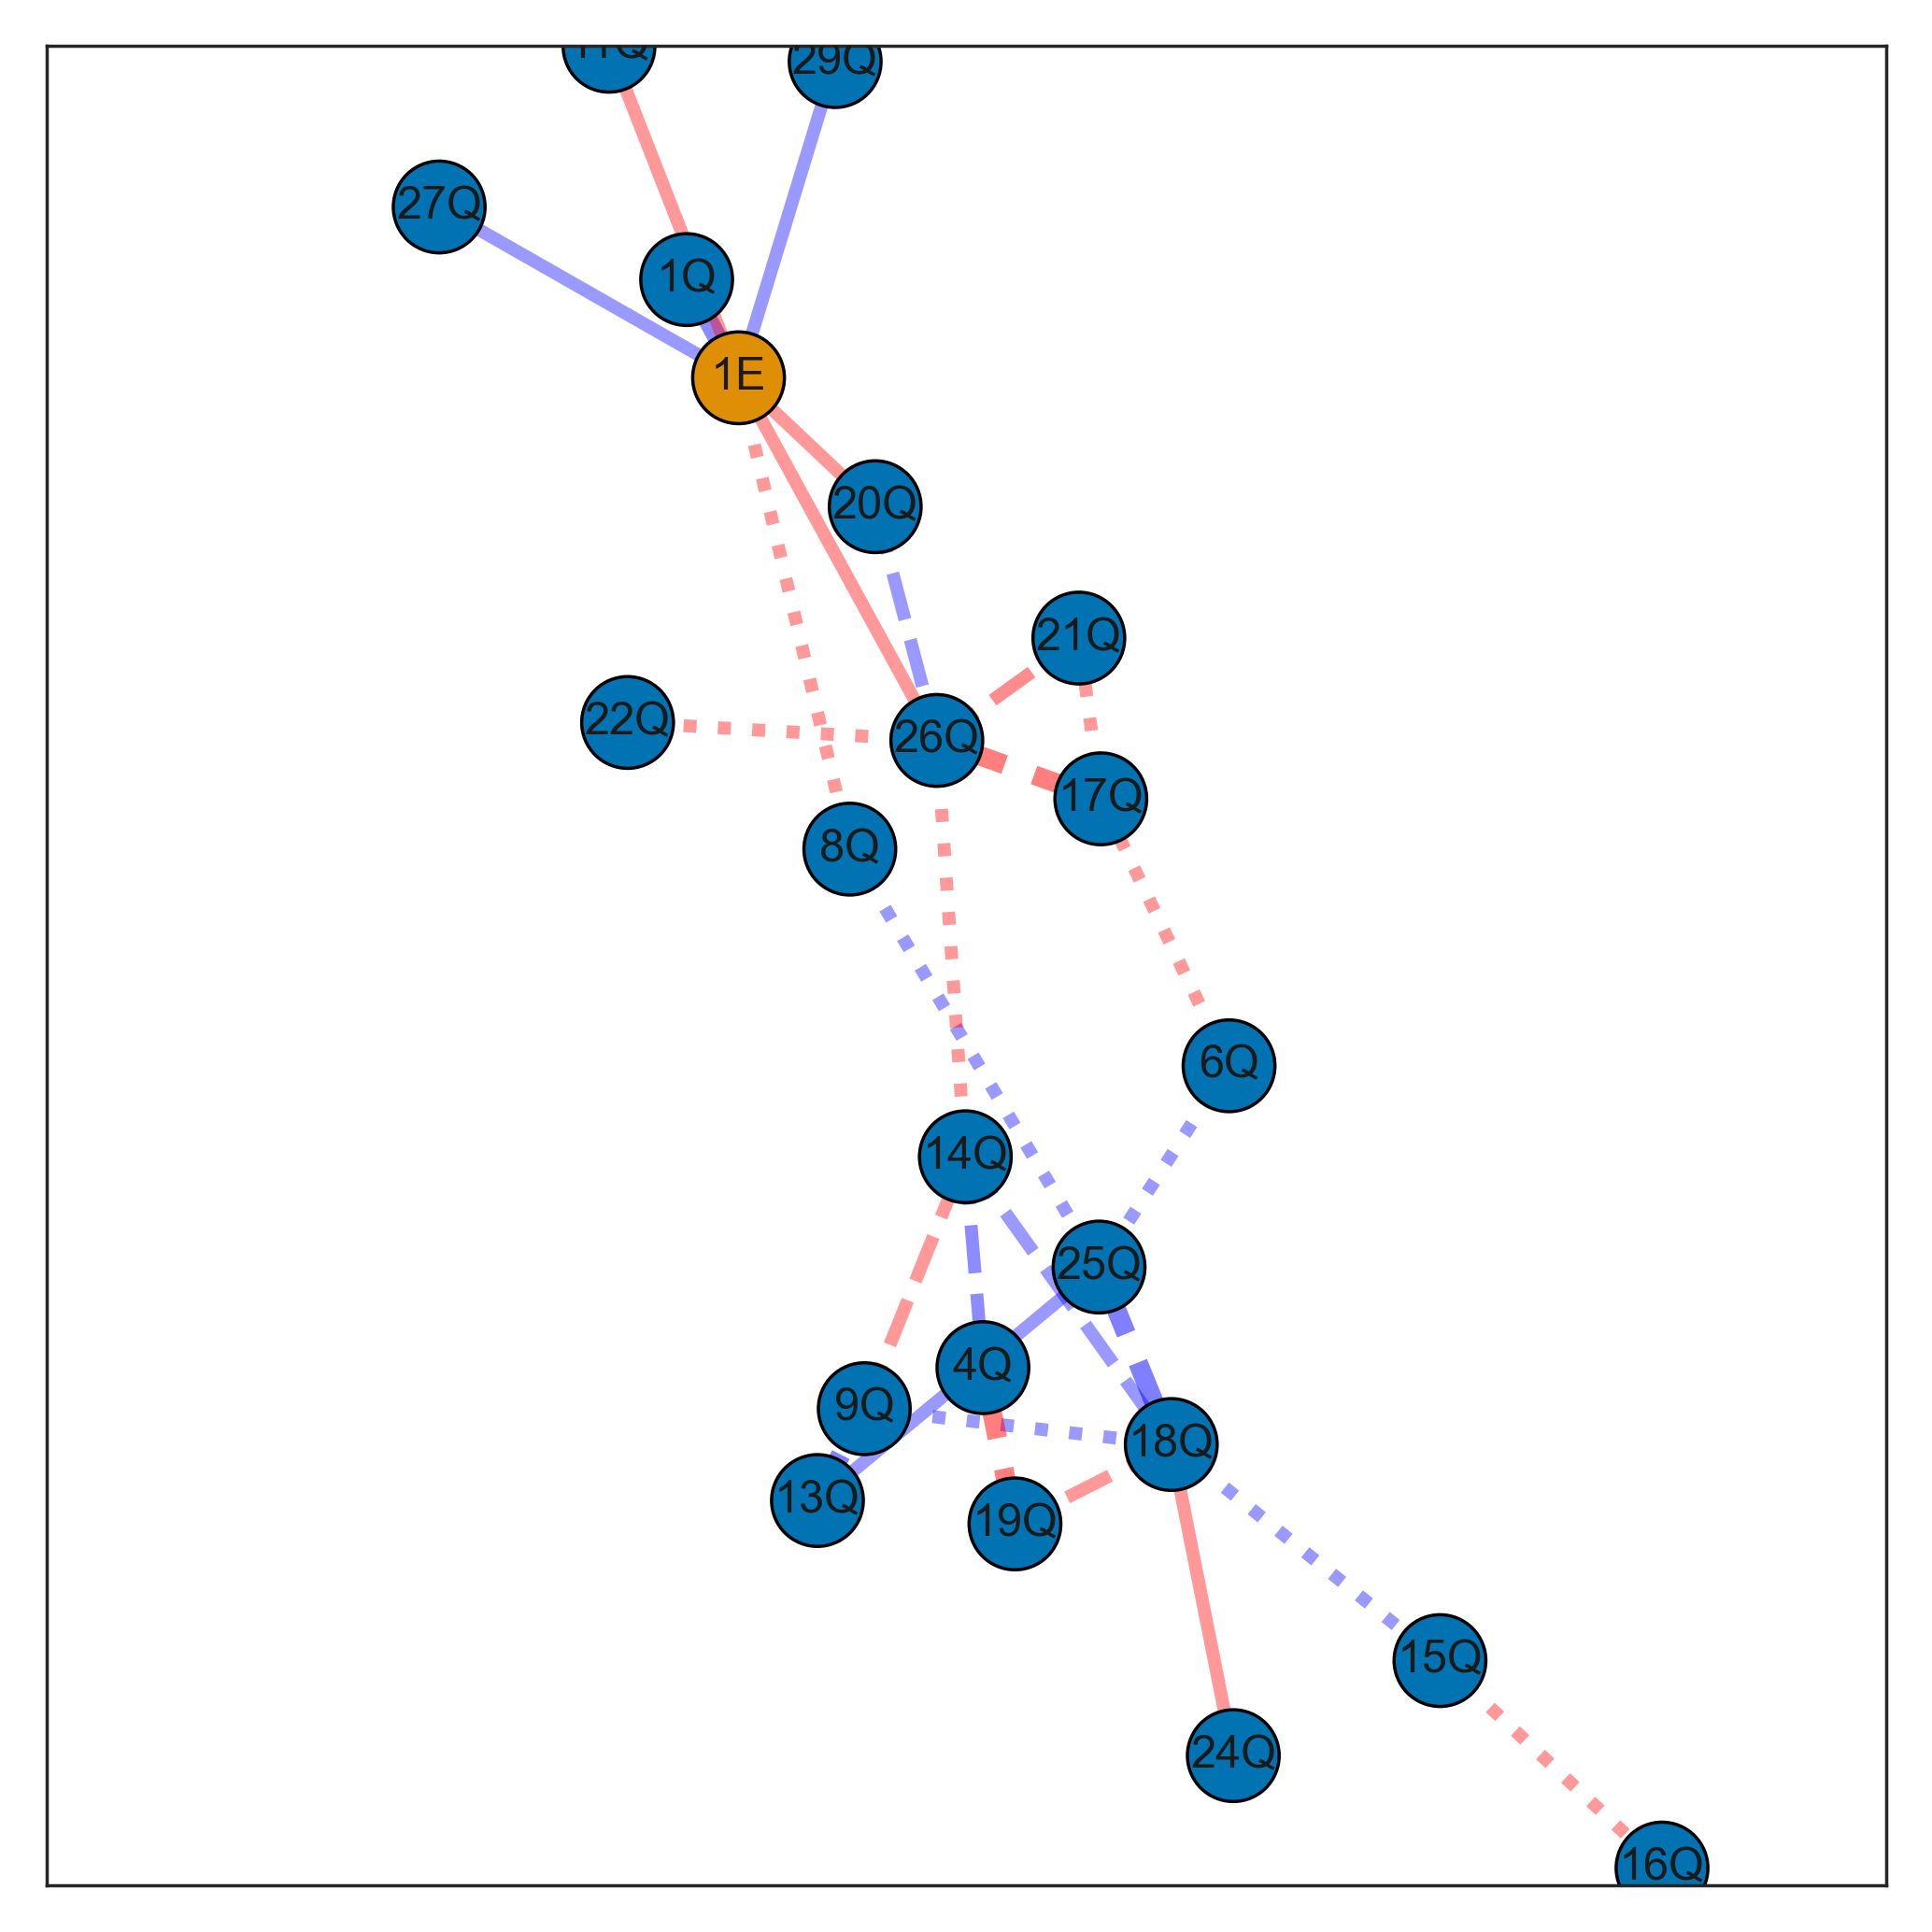

In [102]:
diff_ern, colors, styles = get_diff_graph(ern_graph, crn_graph,threshold=0.02)

draw_graph_diff_full(
    diff_ern, 
    colors=colors, 
    linestyle=styles, 
    seed=2, 
    no_purple=True, 
    scale=1
)

Calculate net predictability

In [103]:
G_ = diff_ern.copy()       
ern_crn_diff_matrix = nx.to_numpy_array(G_)
ern_crn_diff_matrix_df = pd.DataFrame(ern_crn_diff_matrix, columns=G_.nodes(), index=G_.nodes())

In [104]:
ern_crn_diff_predictability = calculate_nodes_predictability(X_ern.rename(columns=mapping_ern), ern_crn_diff_matrix_df)

In [105]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_crn_diff_predictability)

1E        1Q        8Q       11Q       20Q      26Q       22Q  \
0  0.06739  0.030042  0.002897  0.000405  0.023883  0.13408  0.062762   

        27Q       29Q        6Q        9Q       24Q       25Q       14Q  \
0  0.015771  0.008445  0.000932  0.007965  0.075104  0.018435  0.625507   

        18Q       4Q       17Q       19Q       21Q      13Q       15Q  \
0  0.415916  0.69839  0.017891  0.582884  0.057032  0.00268  0.199009   

        16Q  
0  0.147104

Save the graph

In [52]:
nx.write_gml(diff_ern, '../data/graphs/ern_crn_diff_graph.gml')
ern_crn_diff_matrix_df.to_pickle(f'../data/precision_matrixes/{dataset}/precision_matrix_ern_crn_diff.pkl')

- ERN + cov - CRN model

1E,3C,0.697 enlarged/dropped blue
1E,10Q,-0.014 unique ERN but too low
1E,29Q,0.005 unique ERN but too low
1E,4C,0.015 unique ERN but too low
3C,12Q,-0.011 unique ERN but too low
1Q,6Q,-0.368 enlarged/dropped red
8Q,29Q,0.006 unique ERN but too low
8Q,4C,-0.116 enlarged/dropped red
20Q,26Q,0.051 enlarged/dropped blue
4C,11Q,0.044 enlarged/dropped blue
4C,14Q,-0.006 unique ERN but too low
6Q,15Q,0.081 enlarged/dropped blue
6Q,25Q,0.102 enlarged/dropped blue
25Q,11Q,-0.18 enlarged/dropped red
25Q,2Q,-0.178 enlarged/dropped red
11Q,2Q,-0.279 enlarged/dropped red
26Q,17Q,-0.147 enlarged/dropped red
15Q,2Q,-0.044 enlarged/dropped red
16Q,19Q,0.252 enlarged/dropped blue


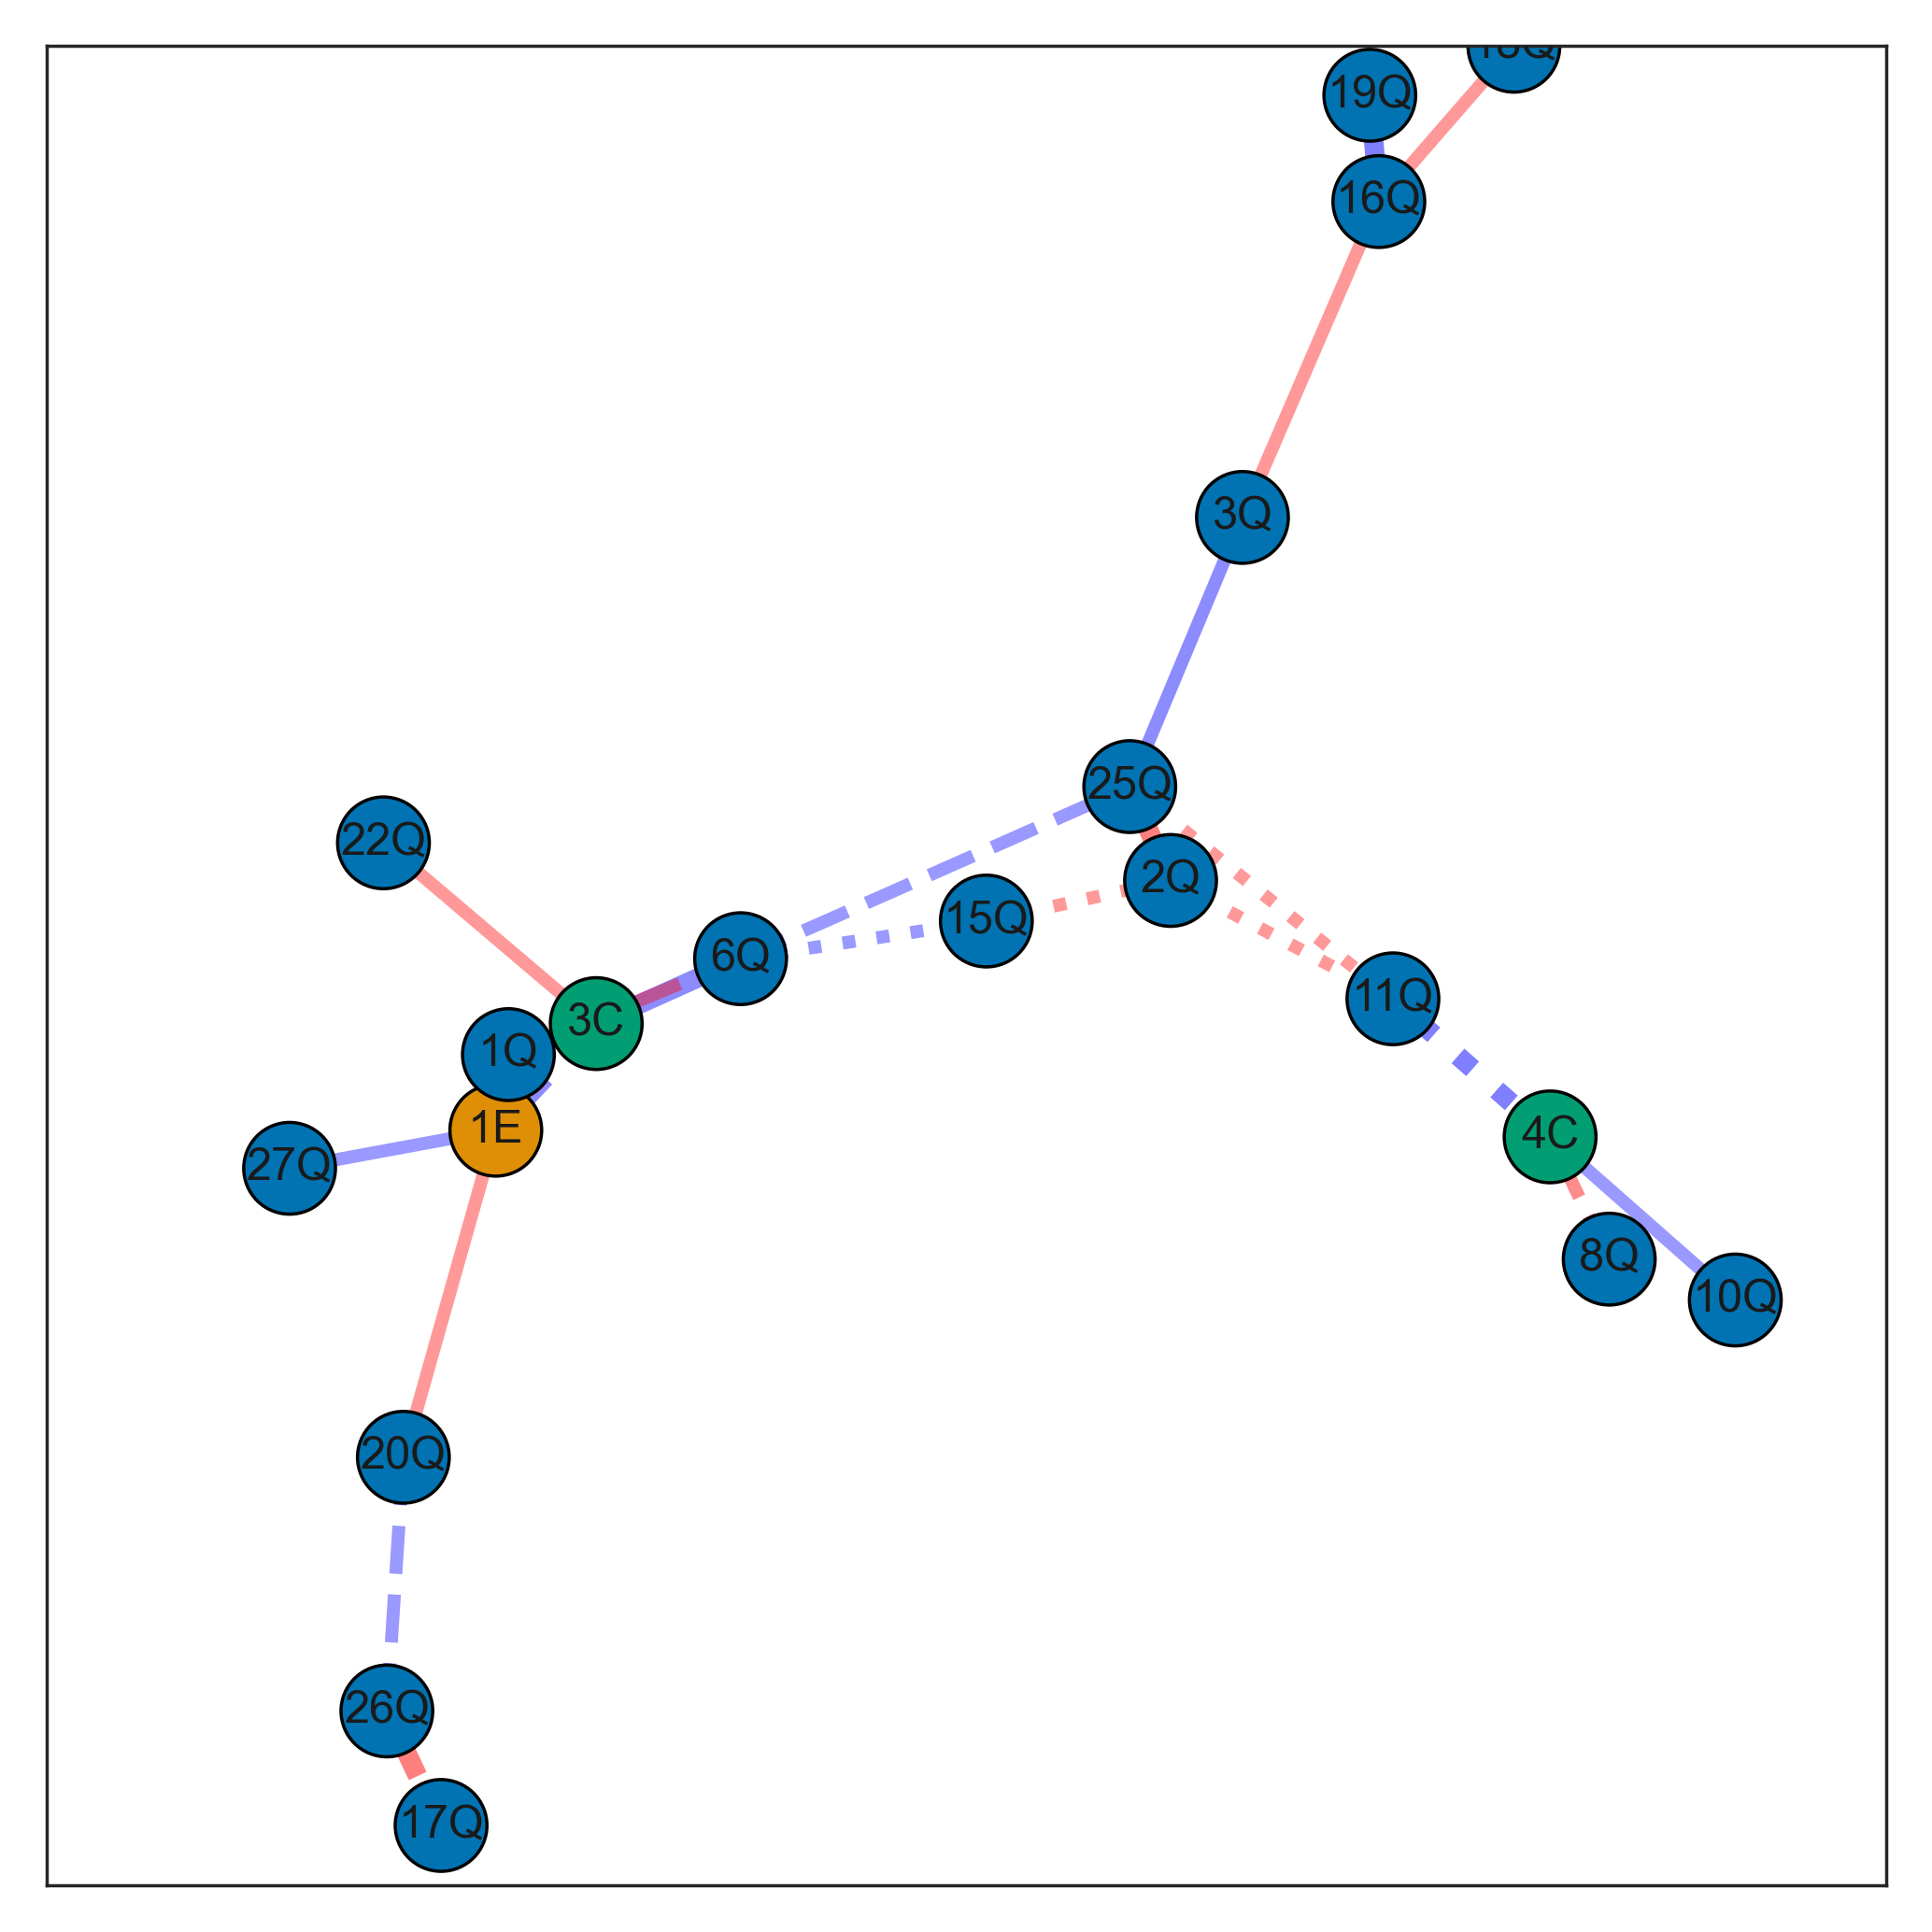

In [55]:
diff_ern, colors, styles = get_diff_graph(ern_cov_graph, crn_cov_graph,threshold=0.02 ) # 4647, 3, 6, 9
draw_graph_diff_full(
    diff_ern, 
    colors=colors, 
    linestyle=styles, 
    seed=1, 
    no_purple=True
) # te siec do programu graficznego

Calculate net predictability

In [56]:
G_ = diff_ern.copy()       
ern_crn_diff_matrix = nx.to_numpy_array(G_)
ern_crn_diff_matrix_df = pd.DataFrame(ern_crn_diff_matrix, columns=G_.nodes(), index=G_.nodes())

In [57]:
ern_crn_diff_predictability = calculate_nodes_predictability(X_ern_cov.rename(columns=mapping_ern), ern_crn_diff_matrix_df)

In [58]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_crn_diff_predictability)

1E        3C        1Q       8Q      10Q       20Q       27Q  \
0  0.291565  0.283414  0.292888  0.01251  0.00095  0.023883  0.015771   

         4C        6Q       22Q       25Q       11Q      18Q       26Q  \
0  0.023491  0.334528  0.006172  0.100309  0.255216  0.01308  0.037997   

        15Q       16Q       17Q        3Q        2Q       19Q  
0  0.080184  0.102009  0.009333  0.006145  0.236909  0.091375

Save the graph

In [59]:
nx.write_gml(diff_ern, '../data/graphs/ern_crn_cov_diff_graph.gml')
ern_crn_diff_matrix_df.to_pickle(f'../data/precision_matrixes/{dataset}/precision_matrix_ern_crn_cov_diff.pkl')

### 2. Based on links: ERN \ (ERN & CRN)

Draw only links that exists in ERN net and do not exist in CRN net

Extract links from precision matrices

In [232]:
ern_precision = precision_matrixes[0]
ern_cov_precision = precision_matrixes[1]
crn_precision = precision_matrixes[2]
crn_cov_precision = precision_matrixes[3]

precision_matrices = [ern_precision, ern_cov_precision, crn_precision, crn_cov_precision]

In [291]:
if test:
    test_links = []

    for matrix_ in precision_matrixes_test:
        this_links = leave_n_edges_from_eeg(get_links(matrix_, threshold=0.02), N=3)
        test_links.append(this_links)
else:
    links = []

    for matrix_ in precision_matrices:
        this_links = leave_n_edges_from_eeg(get_links(matrix_, threshold=0.02), N=3)
        links.append(this_links)

Nodes labels mappers

In [292]:
mapping_ern = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    # "OCI-R": "11Q",
    "WBSI": "11Q",
    "IUS-P": "12Q",
    "IUS-I": "13Q",
    "SES": "14Q",
    'BAS_D': "15Q",
    'BAS_PRZY': "16Q",
    'BAS_NAG': "17Q",
    'INDEC_F': "18Q",
    'PUN': "19Q",
    'REW': "20Q",
    'HARM': "21Q",
    'T-CTR': "22Q",
    "OT": "23Q",
    'OB_PERF': "24Q",
    'CMDA': "25Q",
    'PS': "26Q",
    'G_SE': "27Q",
    'AMB': "28Q",
    'PRED': "29Q",
    'STAND': "30Q",   
    "Age": "1C",
    # "Sex": "2C",
    "Handness": "2C",
    'e_ERN': "1E",
    'e_LT_F': "3C",
    'performance': "4C",
}

mapping_crn = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    # "OCI-R": "11Q",
    "WBSI": "11Q",
    "IUS-P": "12Q",
    "IUS-I": "13Q",
    "SES": "14Q",
    'BAS_D': "15Q",
    'BAS_PRZY': "16Q",
    'BAS_NAG': "17Q",
    'INDEC_F': "18Q",
    'PUN': "19Q",
    'REW': "20Q",
    'HARM': "21Q",
    'T-CTR': "22Q",
    "OT": "23Q",
    'OB_PERF': "24Q",
    'CMDA': "25Q",
    'PS': "26Q",
    'G_SE': "27Q",
    'AMB': "28Q",
    'PRED': "29Q",
    'STAND': "30Q",   
    "Age": "1C",
    # "Sex": "2C",
    "Handness": "2C",
    'e_CRN': "1E",
    'e_LT_F2_C': "3C",
    'performance': "4C",
}

Ctreate graphs from provided links

In [293]:
def create_g(links, mapping):
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    return G

In [294]:
ern_graph = create_g(links[0], mapping_ern)
ern_cov_graph = create_g(links[1], mapping_ern)
crn_graph = create_g(links[2], mapping_crn)
crn_cov_graph = create_g(links[3], mapping_crn)

Calculate two graphs difference

- ERN - CRN

In [295]:
diff_graph = ern_graph.copy()

for edge in diff_graph.edges():
    if edge in crn_graph.edges():
        diff_graph.remove_edge(edge[0], edge[1])
diff_graph.remove_nodes_from(list(nx.isolates(diff_graph)))

- ERN + cov - CRN + cov

In [296]:
diff_graph_cov = ern_cov_graph.copy()

for edge in diff_graph_cov.edges():
    print(edge)
    if edge in crn_cov_graph.edges():
        diff_graph_cov.remove_edge(edge[0], edge[1])
diff_graph_cov.remove_nodes_from(list(nx.isolates(diff_graph_cov)))

('1E', '3C')
('1E', '1Q')
('1E', '8Q')
('1E', '20Q')
('1E', '28Q')
('3C', '6Q')
('3C', '22Q')
('1Q', '28Q')
('1Q', '6Q')
('1Q', '7Q')
('1Q', '23Q')
('1Q', '11Q')
('1Q', '18Q')
('8Q', '15Q')
('8Q', '16Q')
('8Q', '7Q')
('8Q', '9Q')
('8Q', '10Q')
('8Q', '18Q')
('8Q', '24Q')
('8Q', '26Q')
('8Q', '4C')
('20Q', '1C')
('20Q', '5Q')
('20Q', '6Q')
('20Q', '15Q')
('20Q', '16Q')
('20Q', '17Q')
('20Q', '23Q')
('20Q', '27Q')
('20Q', '12Q')
('28Q', '6Q')
('28Q', '17Q')
('28Q', '7Q')
('28Q', '18Q')
('28Q', '22Q')
('28Q', '29Q')
('28Q', '30Q')
('28Q', '12Q')
('6Q', '22Q')
('6Q', '2Q')
('6Q', '3Q')
('6Q', '4Q')
('6Q', '5Q')
('6Q', '15Q')
('6Q', '17Q')
('6Q', '18Q')
('6Q', '19Q')
('6Q', '27Q')
('6Q', '26Q')
('6Q', '30Q')
('17Q', '1C')
('17Q', '2C')
('17Q', '15Q')
('17Q', '16Q')
('17Q', '9Q')
('17Q', '21Q')
('17Q', '27Q')
('17Q', '14Q')
('7Q', '11Q')
('7Q', '23Q')
('7Q', '1C')
('7Q', '5Q')
('7Q', '2C')
('7Q', '3Q')
('7Q', '16Q')
('7Q', '9Q')
('7Q', '29Q')
('18Q', '1C')
('18Q', '2C')
('18Q', '2Q')
('18Q',

##### Draw the graphs

In [297]:
def draw_graph_diff(G, seed=1, pos=None):
    
    cm = 1/2.54
    dpi = 500

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    sns.set_style("white")
    palette = sns.color_palette("colorblind")
            
    G_copy = G.copy()
    edges = G_copy.edges()
    
    for u,v in edges:
        G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
        
    # set nodes colors
    node_color=[palette[0] if node.find('Q') != -1 
                else palette[1]if node.find('E') != -1 
                else palette[2] for node in G_copy.nodes()]
        
    
    # set position
    if pos == None:
        pos_i = nx.spring_layout(G_copy, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=0.9, seed=seed)
        pos=pos_i
        # pos = nx.kamada_kawai_layout(G_copy, pos=pos_i, scale=1)
    else:
        pos = pos
    
    edges = G.edges()
    # print(edges)
           
    weights = []
    for u,v in edges:
        weight = G[u][v]['weight']
        # print(f"{u},{v},{weight}")
        weights.append(weight)

    edge_color = [('red' if edge < 0 else 'blue') for edge in weights]

    weights_alphas = []
    weight_bold = []
    
    for edge_weight in weights:
        if abs(edge_weight) < 0.05:
            alpha = 0.3 
            bold = 2
        elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.09:
            alpha = 0.35
            bold = 2
        elif abs(edge_weight) >= 0.09 and abs(edge_weight) < 0.16:
            alpha = 0.40
            bold = 3
        elif abs(edge_weight) >= 0.16 and abs(edge_weight) < 0.5:
            alpha = 0.45
            bold = 3
        else:
            alpha = 0.6
            bold = 3
        weights_alphas.append(alpha)
        weight_bold.append(bold)
        

        
    fig = plt.figure(3, figsize=(10*cm, 10*cm))
    axes = fig.add_axes([0,0,1,1], aspect=1)
    n = 1
    axes.set_xlim([-n,n])
    axes.set_ylim([-0.8,1.2])
    
    
    nx.draw_networkx_nodes(
        G, 
        pos=pos,
        linewidths=0.5,
        edgecolors='black',
        node_size = 200,
        node_color=node_color,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=7,
    )
    
    nx.draw_networkx_edges(
        G, 
        pos=pos,
        edgelist = G.edges(),
        edge_color = edge_color,
        alpha=weights_alphas,
        width = weight_bold,
    )
    
    plt.show()   

Positions (manifold)

In [298]:
from sklearn import manifold

def manifold_position(df, node_list, mapper):
    node_position_model = manifold.LocallyLinearEmbedding(
        n_components=2, eigen_solver="dense", n_neighbors=4
    )
    
    df_ = df.rename(columns = mapper)
    
    df_ = df_[node_list]
    
    X = df_.to_numpy()
    X -= X.mean(axis=0) # data is centered in the model (assume_centered=False)
    X /= X.std(axis=0)

    embedding = node_position_model.fit_transform(X.T).T
    
    pos = dict()
    for index, node in enumerate(node_list):
        pos[node] = [embedding[0][index], embedding[1][index]]
    
    return pos

In [299]:
node_list = list(diff_graph.nodes())
pos = manifold_position(results_ern_df, node_list, mapping_ern)

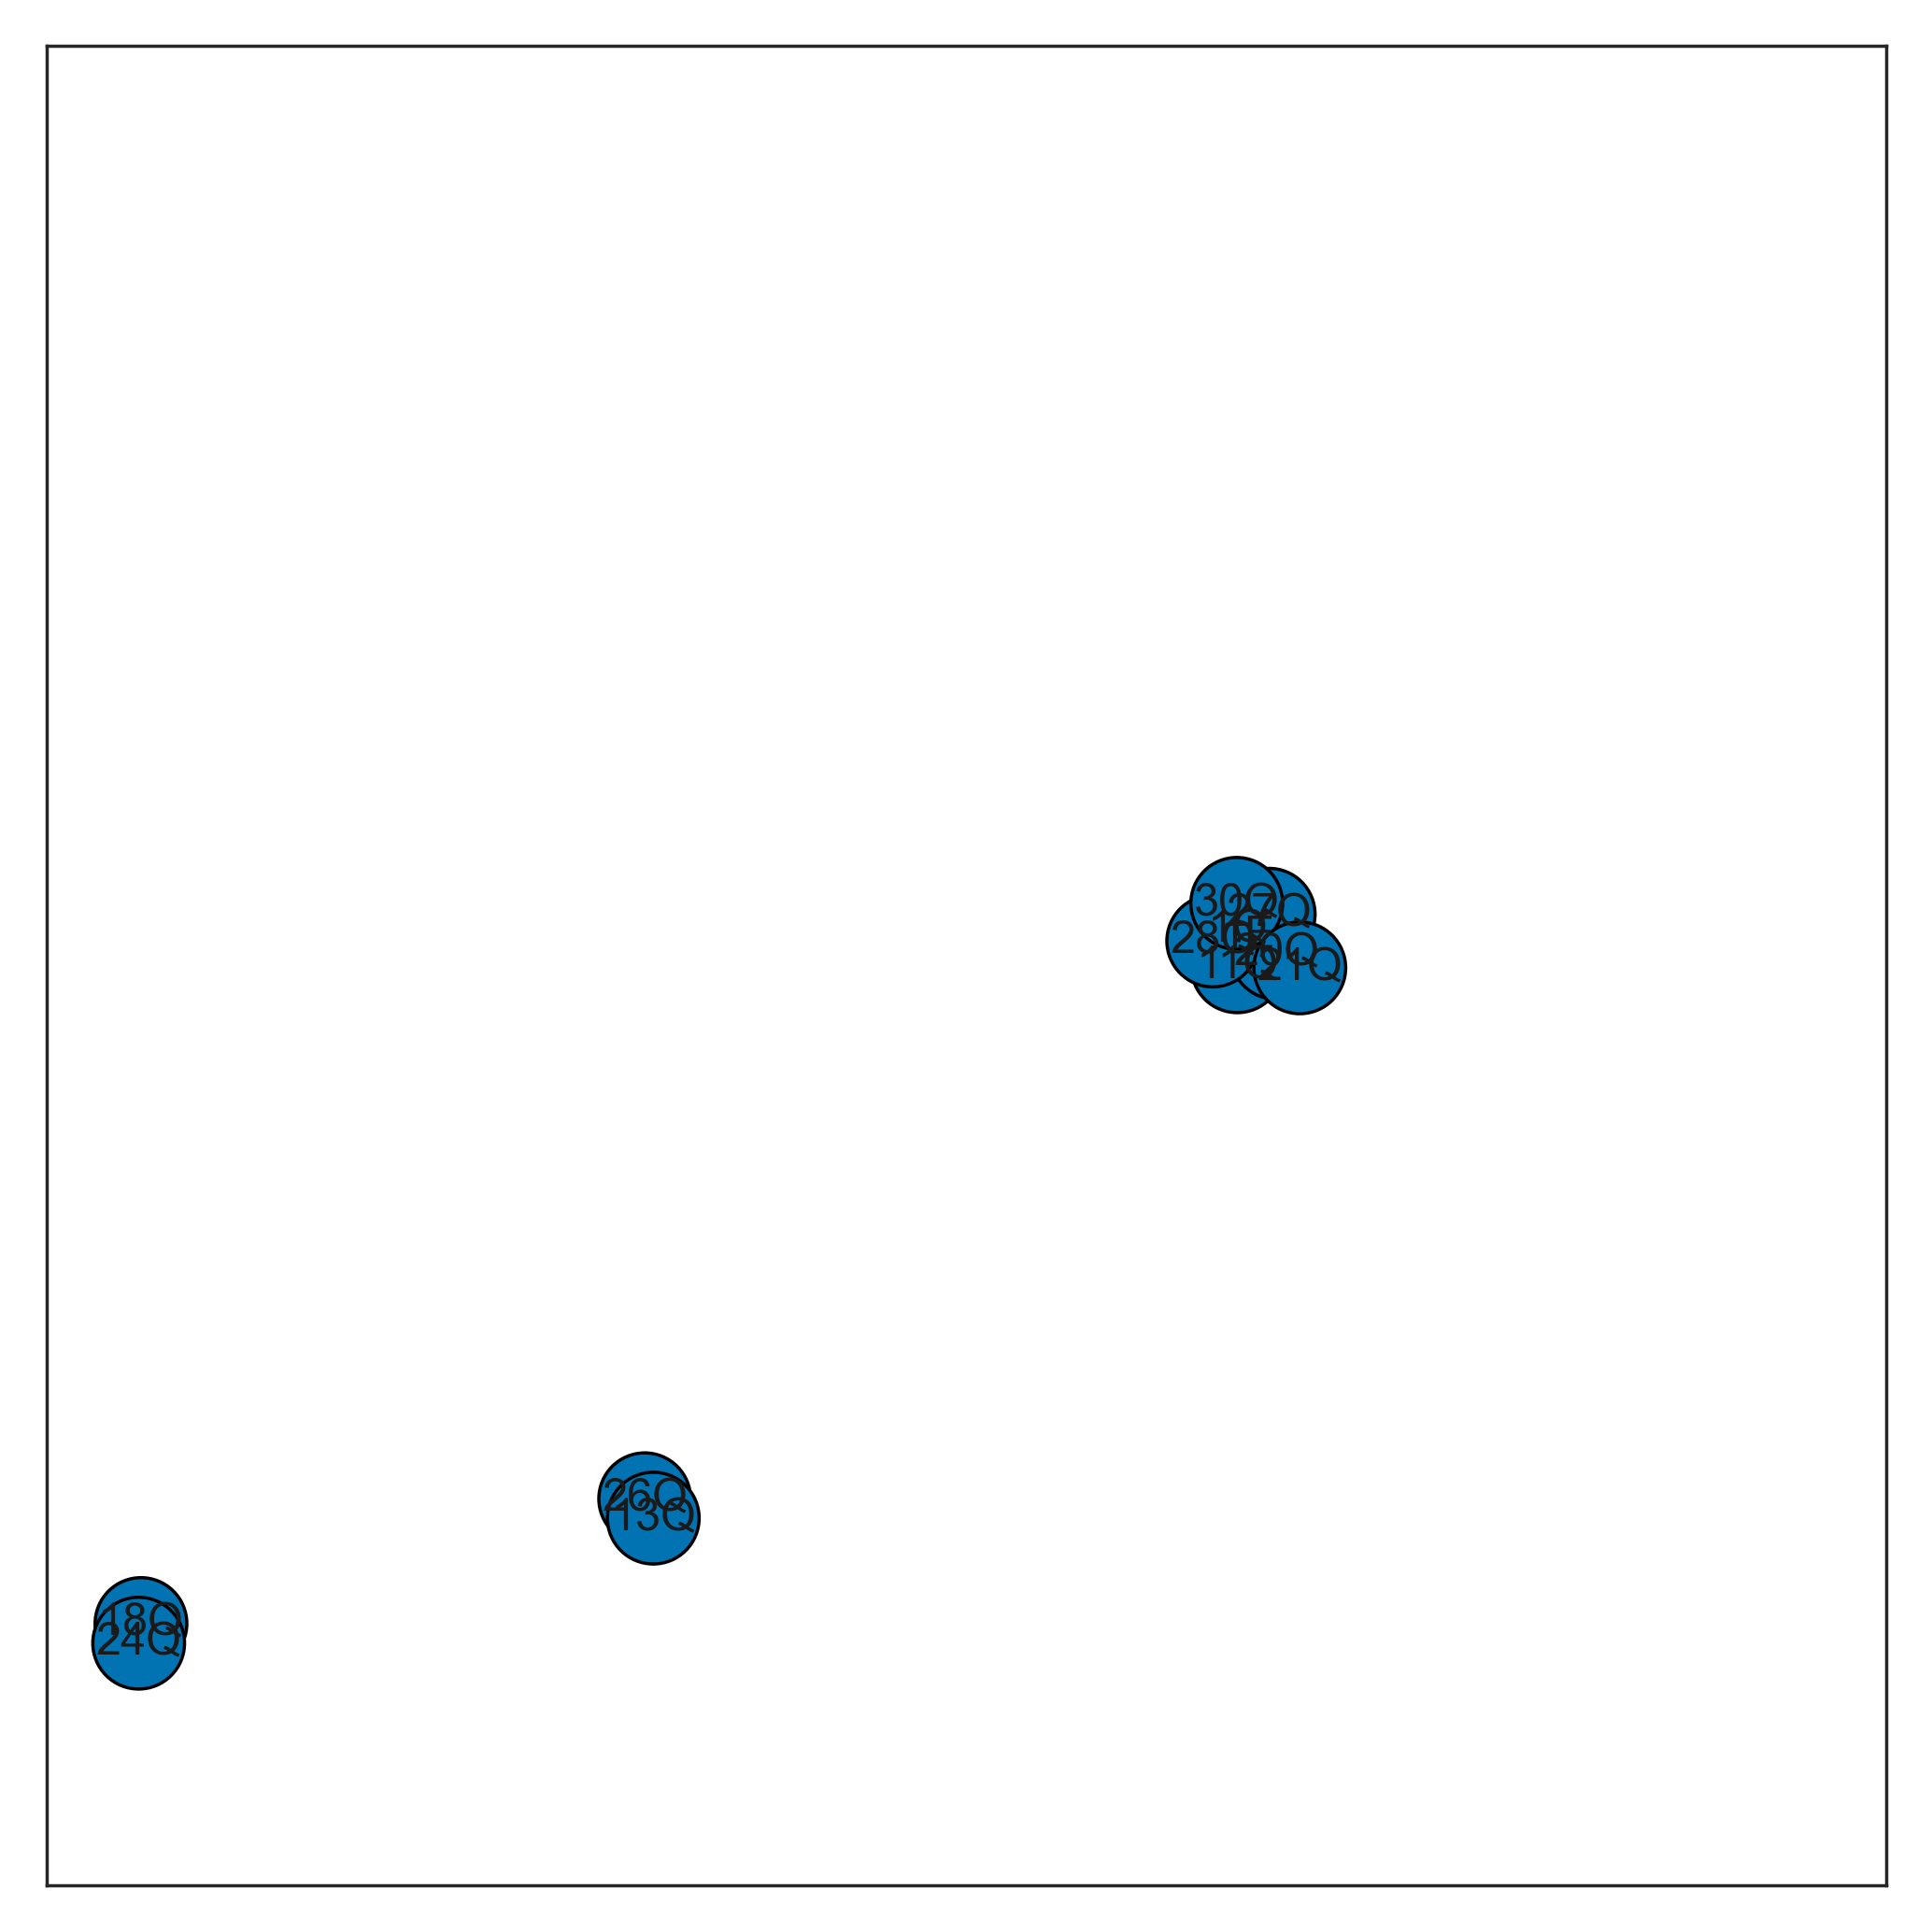

In [300]:
draw_graph_diff(diff_graph, seed=12, pos=None) # draw later with https://github.com/gephi/gephi/wiki

In [301]:
# node_list = list(diff_graph_cov.nodes())
# pos = manifold_position(results_ern_lat_demo_df, node_list, mapping_ern)

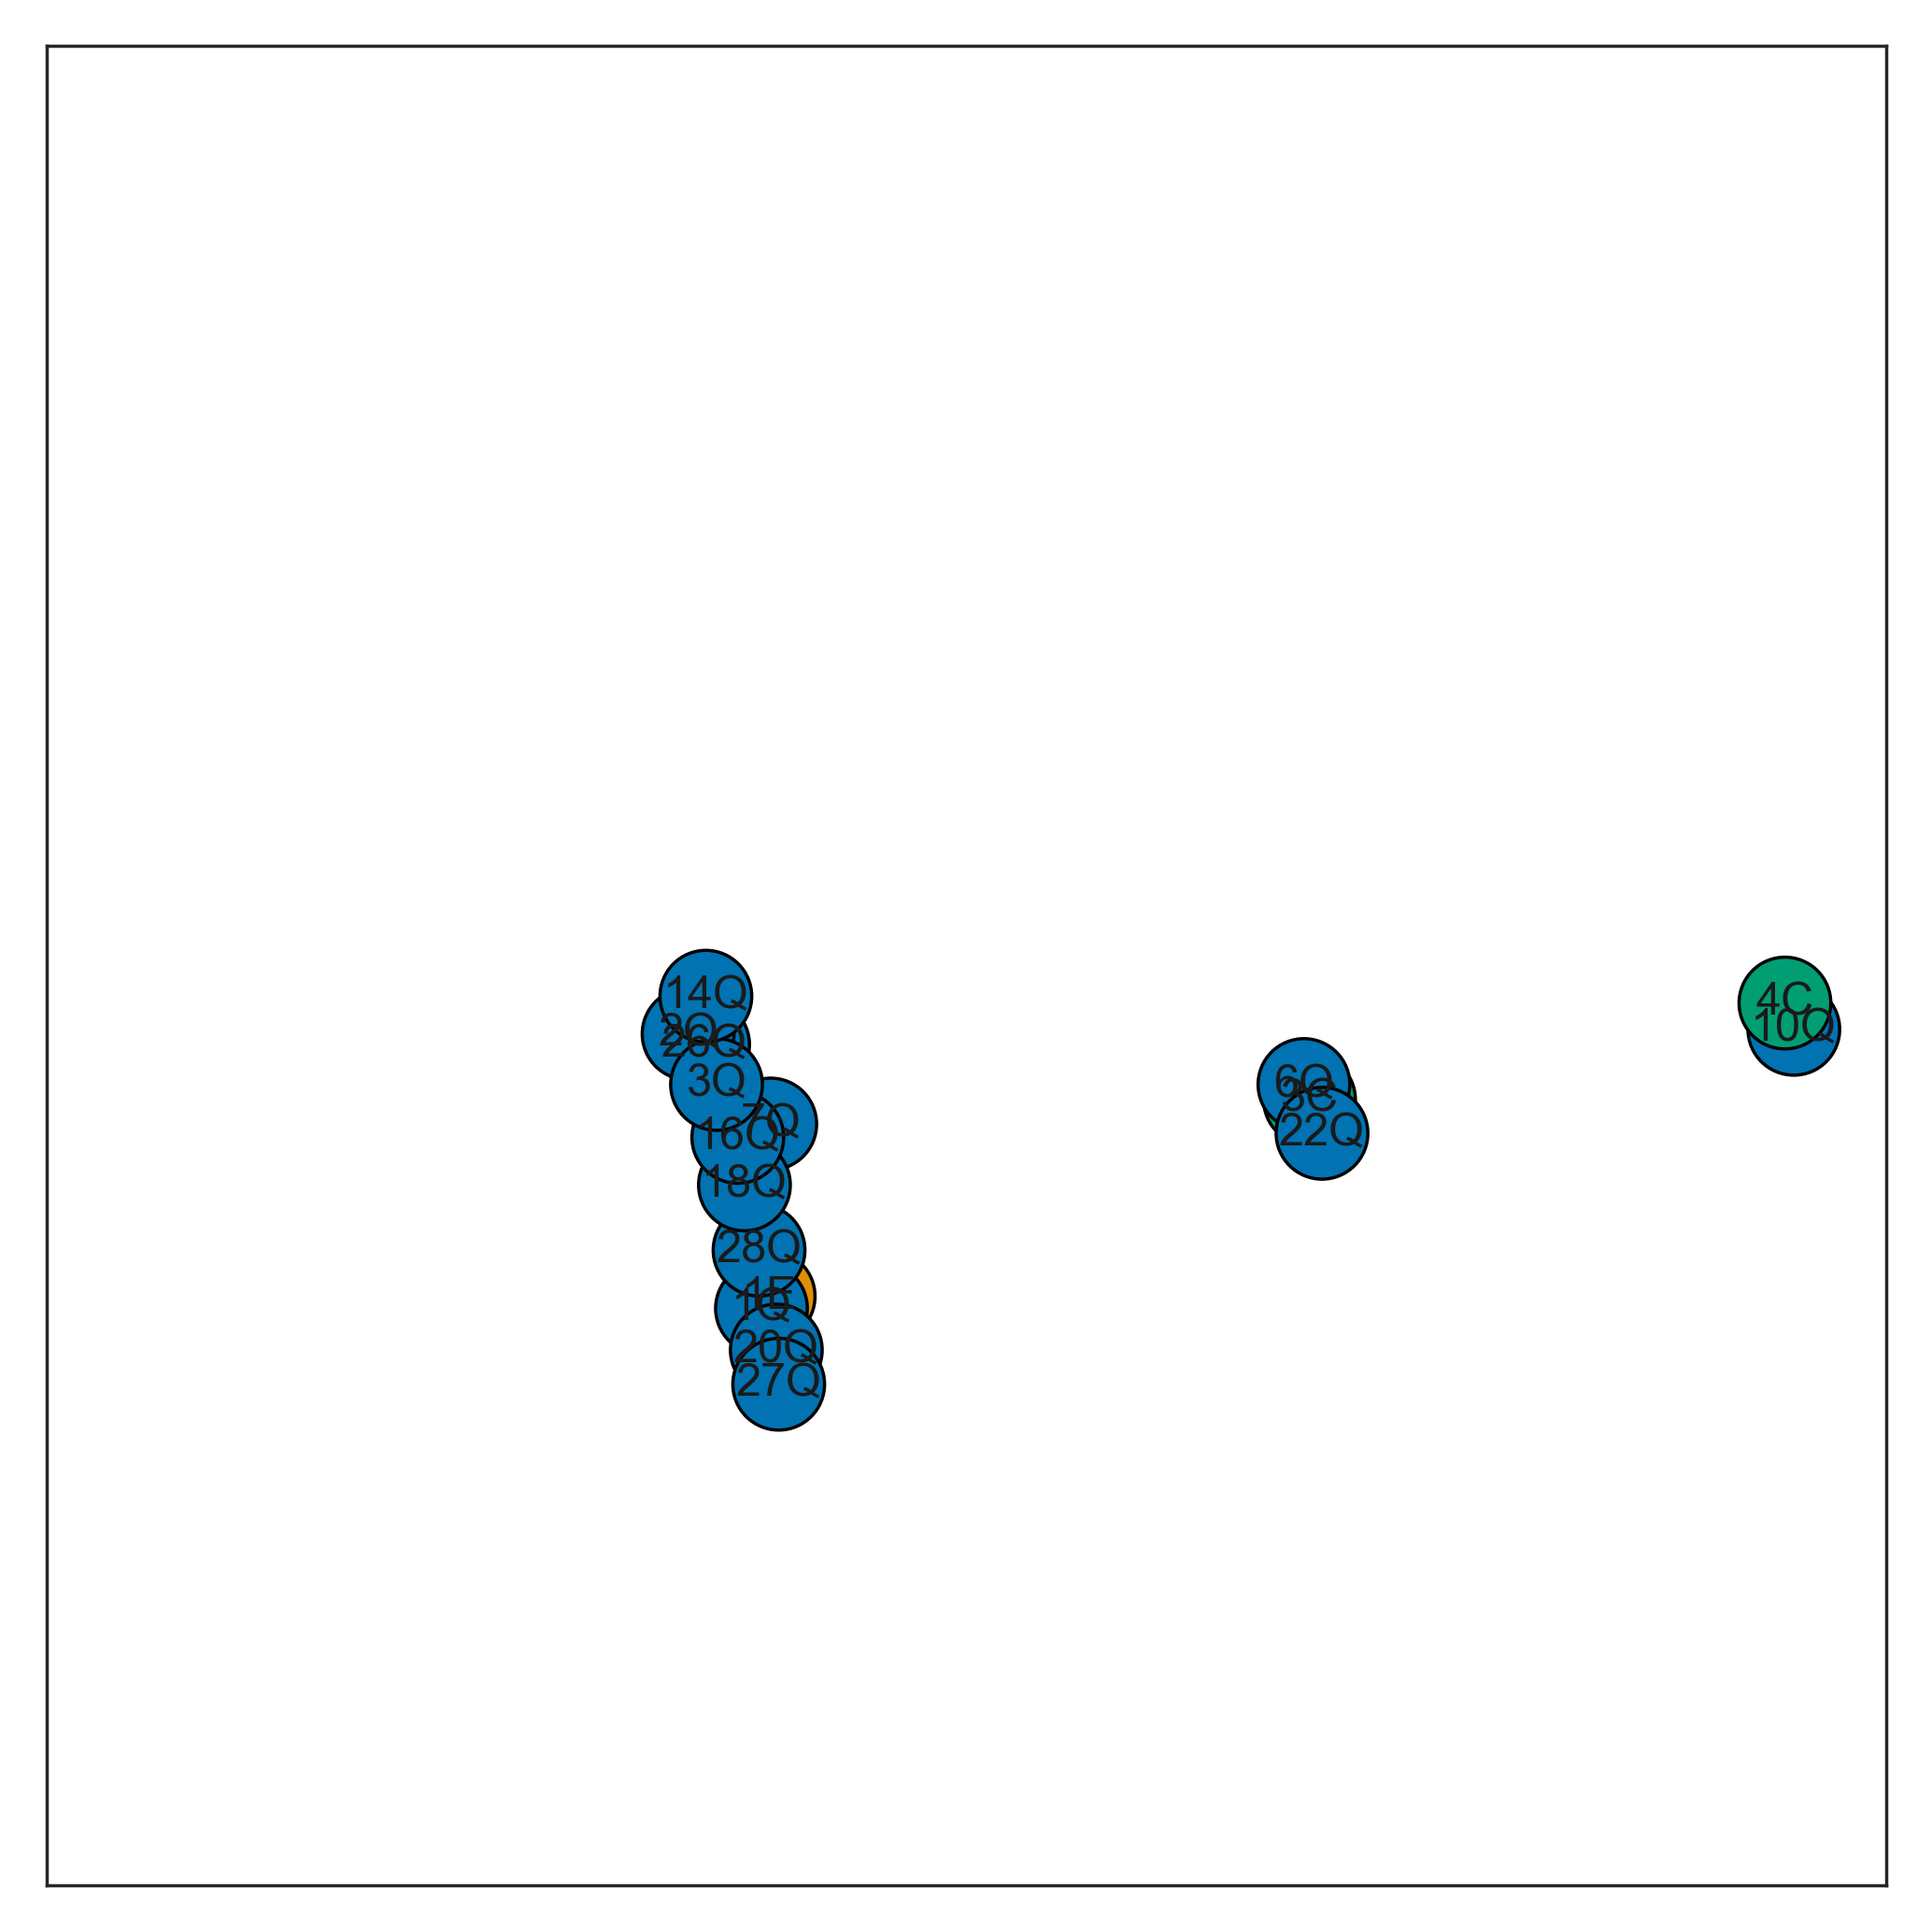

In [302]:
draw_graph_diff(diff_graph_cov, pos=None, seed=11)

---
## Draw legend

In [166]:
legend_labels = {
    "1Q: Rumination": "1Q",
    "2Q: DASS-21 Stress": "2Q",
    "3Q: DASS-21 Depression": "3Q",
    "4Q: STAI-T": "4Q",
    "5Q: STAI-S S1-S2": '5Q',
    "6Q: Behavioral Inhibition": "6Q",
    "7Q: Obsessing": "7Q",
    "8Q: Hoarding": "8Q",
    "9Q: Ordering": "9Q",
    "10Q: Checking": "10Q",
    "11Q: OCI-R": "11Q",
    "12Q: Thought Supression": "12Q",
    "13Q: Prospective IU": "13Q",
    "14Q: Inhibitory IU": "14Q",
    "15Q: Self-esteem": "15Q",
    '16Q: BAS Drive': "16Q",
    '17Q: BAS Fun Seeking': "17Q",
    '18Q: BAS Reward Responsiveness': "18Q",
    '19Q: Nonforgivness': "19Q",
    '20Q: Indecisivness': "20Q",
    '21Q: Punishment Sensitivity': "21Q",
    '22Q: Reward Sensitivity': "22Q",
    '23Q: Inflated harm responsibility': "23Q",
    '24Q: Thought Control': "24Q",
    "25Q: Threat Overestimation": "25Q",
    '26Q: OB Perfectionism': "26Q",
    '27Q: Concern over Mistakes': "27Q",
    '28Q: Personal Standards': "28Q",
    '29Q: Guilt Sensitivity': "29Q",
    '30Q: Avoidance of Ambiguity': "30Q",
    '31Q: Need for Predictability': "31Q",
    '32Q: High standards': "32Q",   
    "1C: Age": "1C",
    "2C: Sex": "2C",
    "3C: Handedness": "3C",
    '4C: ERP latency': "4C",
    '5C: Performance': "5C",
    '1E: ERN': "1E",
    '2E: CRN': "2E",
}

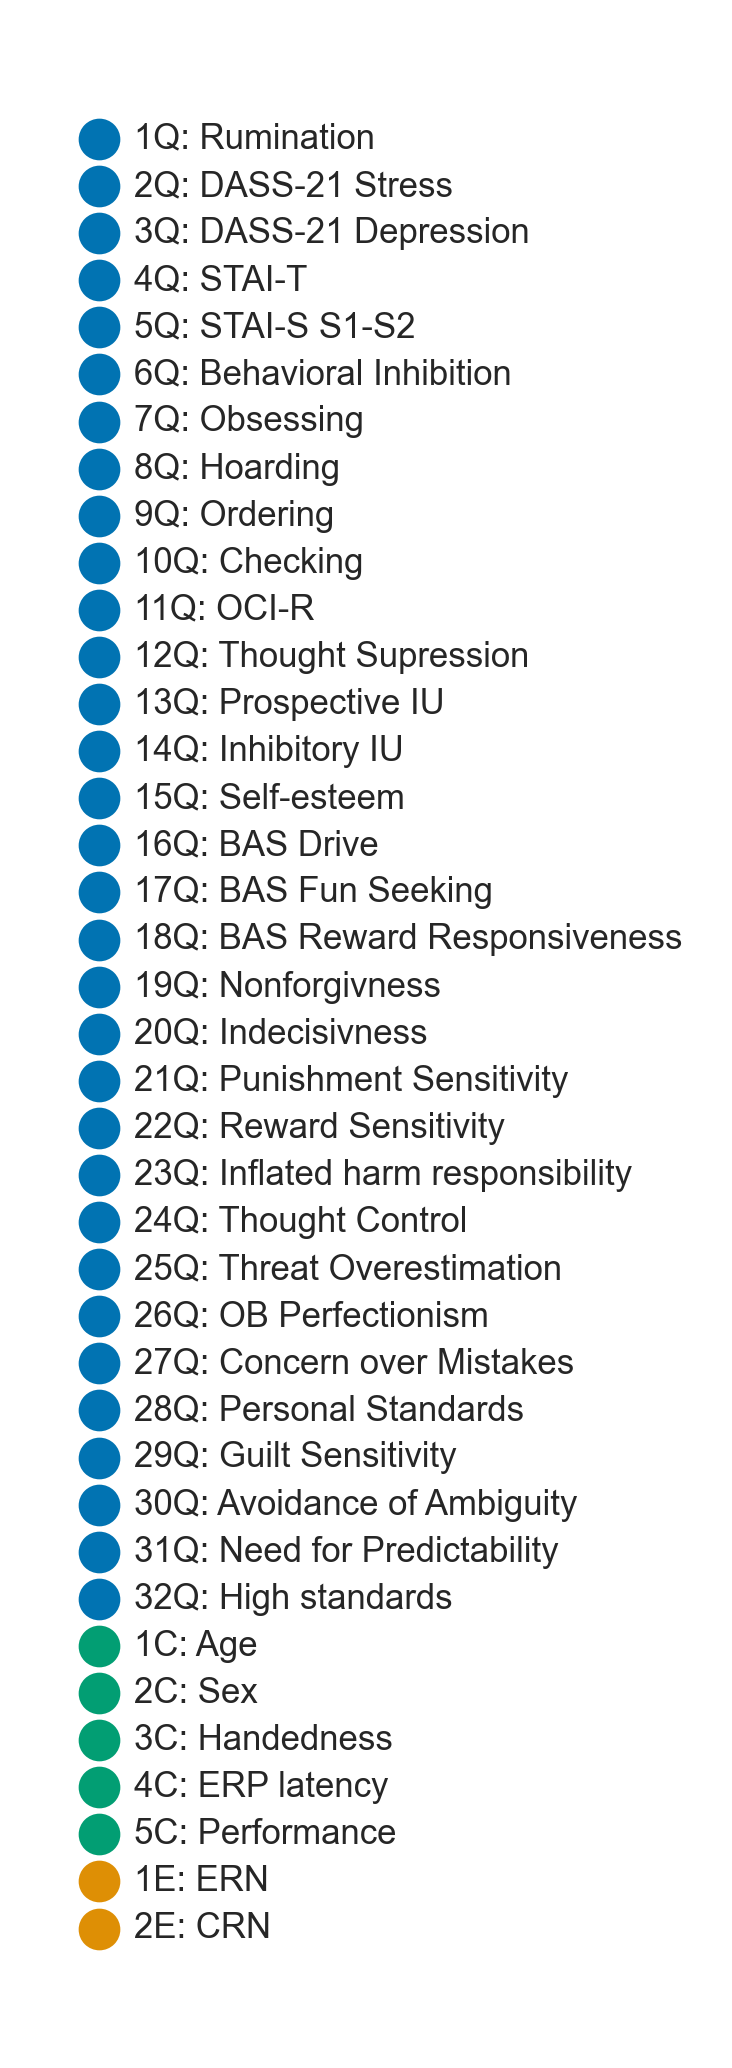

In [167]:
cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
sns.set_style("white")


palette = sns.color_palette("colorblind")

fig = plt.figure(3, figsize=(10*cm, 10*cm))
ax = fig.add_axes([0,0,1,1], aspect=1)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
    
# # change default range so that new circles will work
# ax.set_xlim((0, 10))
# ax.set_ylim((0, 10))
# some data
x = [0.5]*len(legend_labels)
y = np.linspace(0,1,len(legend_labels))

nodes_color=[palette[0] if item[1].find('Q') != -1 
                else palette[1]if item[1].find('E') != -1 
                else palette[2] for item in legend_labels.items()]


    
# ax.plot(x, y, 'o', color=nodes_color,  markersize=4)

for i, item in enumerate(legend_labels.items()):
    item_index = len(legend_labels) - i - 1
    
    ax.plot(
        x[item_index],
        y[item_index], 
        'o', 
        markersize=5,
        color=nodes_color[i],
    )
    
    plt.annotate(
        item[0],                       # label text
        (x[item_index], y[item_index]),                    # (x, y)
        textcoords="offset points",   
        xytext=(5, -1.35),               # (x, y) offset amount
        ha='left',
        fontsize=5
    )
    
plt.show()